# CT7160NI Computer Vision Coursework
## 03 - Centralized Model Training

**Project:** Deep Learning-Based Plant Species Classification  
**Dataset:** Oxford 102 Flower Dataset  
**Author:** Rishav Singh  
**Date:** January 2025

---

This notebook provides centralized training for all three models:
1. **Baseline CNN** - Custom CNN architecture from scratch
2. **ResNet50** - Transfer learning with ImageNet pre-trained weights
3. **EfficientNet-B3** - Efficient architecture with compound scaling

### Contents
1. Setup and Imports
2. Configuration and Utilities
3. Baseline CNN Training
4. ResNet50 Training (Two-Phase)
5. EfficientNet-B3 Training
6. Training Visualization and Analysis
7. Model Comparison and Summary

---

**Note:** This notebook centralizes all training code to ensure consistency and reproducibility.

In [1]:
# Setup: Add project root to Python path
import sys
import os
from pathlib import Path

# Find project root
notebook_dir = Path().resolve()
project_root = None

if notebook_dir.name == 'notebooks' and (notebook_dir.parent / 'src').exists():
    project_root = notebook_dir.parent
elif (notebook_dir / 'src').exists():
    project_root = notebook_dir
elif (notebook_dir.parent / 'src').exists():
    project_root = notebook_dir.parent
else:
    current = notebook_dir
    while current != current.parent:
        if (current / 'src').exists():
            project_root = current
            break
        current = current.parent

if project_root:
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    os.chdir(project_root)
    print(f"✓ Project root: {project_root}")
else:
    print("⚠ Warning: Could not find project root. Using current directory.")

# Verify imports
try:
    from src.models import BaselineCNN
    from src.models.resnet_model import ResNetClassifier
    from src.models.efficientnet_model import EfficientNetClassifier
    from src.data.data_loader import create_dataloaders
    from src.training import Trainer
    from src.evaluation.visualization import plot_training_history
    print("✓ All imports successful!")
except ImportError as e:
    print(f"✗ Import error: {e}")

✓ Project root: D:\MSc Islington\Computer Vision\Deep-Learning-Based-Plant-Species-Classification-Using-Leaf-and-Flower-Images\plant-species-classification
✓ All imports successful!


In [2]:
# Standard library imports
import time
from datetime import datetime
from pathlib import Path
import json

# Scientific computing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')
sns.set_palette("husl")

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import GradScaler, autocast
try:
    from torchsummary import summary
except ImportError:
    summary = None  # Will handle gracefully in visualize_model_architecture

# Progress bars
from tqdm import tqdm

# Set random seeds for reproducibility
def set_seed(seed=42):
    """Set random seeds for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("✓ Random seeds set for reproducibility")

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✓ Using device: {device}")
if device == 'cuda':
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  CUDA Version: {torch.version.cuda}")
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"  GPU Memory: {gpu_memory_gb:.2f} GB")
    torch.backends.cudnn.benchmark = True  # Optimize for consistent input sizes
else:
    print("  ⚠ CUDA not available, using CPU (training will be slow)")

✓ Random seeds set for reproducibility
✓ Using device: cuda
  GPU: NVIDIA GeForce RTX 2050
  CUDA Version: 12.1
  GPU Memory: 4.29 GB


## 2. Configuration and Utilities

Define shared configurations and utility functions for training all models.

In [3]:
# Shared configuration
SHARED_CONFIG = {
    'data_dir': 'data/raw/oxford_flowers_102',
    'batch_size': 16,  # Optimized for GPU memory
    'num_workers': 0,  # Use 0 for Windows compatibility
    'use_masks': False,
    'apply_background_removal': False,
    'use_albumentations': True,
    'use_weighted_sampler': True,
    'use_class_weights': True,
    'save_dir': 'results/models',
    'metrics_dir': 'results/metrics',
    'figures_dir': 'results/figures',
}

# Create directories
for dir_path in [SHARED_CONFIG['save_dir'], SHARED_CONFIG['metrics_dir'], SHARED_CONFIG['figures_dir']]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

print("✓ Configuration loaded and directories created")

✓ Configuration loaded and directories created


In [11]:
def calculate_class_weights(train_loader, device='cuda'):
    """Calculate class weights for imbalanced dataset."""
    train_dataset = train_loader.dataset
    class_counts = np.bincount(train_dataset.labels)
    class_counts = np.maximum(class_counts, 1)  # Avoid division by zero
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * len(class_weights)
    return torch.FloatTensor(class_weights).to(device)

def save_training_metrics(history, model_name, save_dir, phase=None):
    """Save training metrics to a text file."""
    save_path = Path(save_dir)
    save_path.mkdir(parents=True, exist_ok=True)
    
    if phase:
        filename = f"{model_name}_{phase}_training_metrics.txt"
    else:
        filename = f"{model_name}_training_metrics.txt"
    
    filepath = save_path / filename
    
    with open(filepath, 'w') as f:
        f.write("=" * 80 + "\n")
        f.write("TRAINING METRICS\n")
        f.write("=" * 80 + "\n\n")
        
        if phase:
            f.write(f"Phase: {phase.upper()}\n")
        f.write(f"Model: {model_name}\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("=" * 80 + "\n")
        f.write("SUMMARY STATISTICS\n")
        f.write("=" * 80 + "\n\n")
        
        f.write(f"Total Epochs: {len(history['train_loss'])}\n\n")
        
        f.write("Training Metrics:\n")
        f.write(f"  Final Loss: {history['train_loss'][-1]:.6f}\n")
        best_loss_epoch = history['train_loss'].index(min(history['train_loss'])) + 1
        f.write(f"  Best Loss: {min(history['train_loss']):.6f} (Epoch {best_loss_epoch})\n")
        f.write(f"  Final Accuracy: {history['train_acc'][-1]:.2f}%\n")
        best_acc_epoch = history['train_acc'].index(max(history['train_acc'])) + 1
        f.write(f"  Best Accuracy: {max(history['train_acc']):.2f}% (Epoch {best_acc_epoch})\n")
        f.write(f"  Final Top-5 Accuracy: {history['train_top5_acc'][-1]:.2f}%\n")
        best_top5_epoch = history['train_top5_acc'].index(max(history['train_top5_acc'])) + 1
        f.write(f"  Best Top-5 Accuracy: {max(history['train_top5_acc']):.2f}% (Epoch {best_top5_epoch})\n\n")
        
        f.write("Validation Metrics:\n")
        f.write(f"  Final Loss: {history['val_loss'][-1]:.6f}\n")
        best_val_loss_epoch = history['val_loss'].index(min(history['val_loss'])) + 1
        f.write(f"  Best Loss: {min(history['val_loss']):.6f} (Epoch {best_val_loss_epoch})\n")
        f.write(f"  Final Accuracy: {history['val_acc'][-1]:.2f}%\n")
        best_val_acc_epoch = history['val_acc'].index(max(history['val_acc'])) + 1
        f.write(f"  Best Accuracy: {max(history['val_acc']):.2f}% (Epoch {best_val_acc_epoch})\n")
        f.write(f"  Final Top-5 Accuracy: {history['val_top5_acc'][-1]:.2f}%\n")
        best_val_top5_epoch = history['val_top5_acc'].index(max(history['val_top5_acc'])) + 1
        f.write(f"  Best Top-5 Accuracy: {max(history['val_top5_acc']):.2f}% (Epoch {best_val_top5_epoch})\n\n")
        
        f.write("=" * 80 + "\n")
        f.write("DETAILED EPOCH-BY-EPOCH METRICS\n")
        f.write("=" * 80 + "\n\n")
        
        f.write(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Train Top-5':<14} "
                f"{'Val Loss':<12} {'Val Acc':<12} {'Val Top-5':<14} {'LR':<12}\n")
        f.write("-" * 100 + "\n")
        
        for epoch in range(len(history['train_loss'])):
            f.write(f"{epoch+1:<8} "
                   f"{history['train_loss'][epoch]:<12.6f} "
                   f"{history['train_acc'][epoch]:<12.2f} "
                   f"{history['train_top5_acc'][epoch]:<14.2f} "
                   f"{history['val_loss'][epoch]:<12.6f} "
                   f"{history['val_acc'][epoch]:<12.2f} "
                   f"{history['val_top5_acc'][epoch]:<14.2f} "
                   f"{history['learning_rate'][epoch]:<12.2e}\n")
        
        f.write("\n" + "=" * 80 + "\n")
        f.write("END OF METRICS\n")
        f.write("=" * 80 + "\n")
    
    print(f"✓ Training metrics saved to: {filepath}")

def load_training_metrics(model_name, metrics_dir, phase=None):
    """
    Load training metrics from a saved text file and return history dictionary.
    
    Parameters:
    -----------
    model_name : str
        Name of the model
    metrics_dir : str
        Directory containing the metrics file
    phase : str, optional
        Phase name (e.g., 'phase1', 'phase2', or None for combined)
        
    Returns:
    --------
    dict : Training history dictionary with keys:
        - 'train_loss', 'train_acc', 'train_top5_acc'
        - 'val_loss', 'val_acc', 'val_top5_acc'
        - 'learning_rate'
    """
    metrics_path = Path(metrics_dir)
    
    # Create filename
    if phase:
        filename = f"{model_name}_{phase}_training_metrics.txt"
    else:
        filename = f"{model_name}_training_metrics.txt"
    
    filepath = metrics_path / filename
    
    if not filepath.exists():
        raise FileNotFoundError(f"Metrics file not found: {filepath}")
    
    # Initialize history dictionary
    history = {
        'train_loss': [],
        'train_acc': [],
        'train_top5_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_top5_acc': [],
        'learning_rate': []
    }
    
    # Read and parse the file
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    # Find the start of epoch-by-epoch metrics section
    data_start_idx = None
    for i, line in enumerate(lines):
        if 'DETAILED EPOCH-BY-EPOCH METRICS' in line:
            # Skip the separator, blank line, header, and separator line (5 lines total)
            data_start_idx = i + 5
            break
    
    if data_start_idx is None:
        raise ValueError(f"Could not find epoch-by-epoch metrics section in {filepath}")
    
    # Parse each epoch line
    for i in range(data_start_idx, len(lines)):
        line = lines[i].strip()
        
        # Stop if we hit the end marker
        if 'END OF METRICS' in line:
            break
        
        # Skip separator lines and empty lines
        if line.startswith('-') or line.startswith('=') or not line:
            continue
        
        # Parse the epoch data line
        # Format: Epoch    Train Loss   Train Acc    Train Top-5    Val Loss     Val Acc      Val Top-5      LR
        parts = line.split()
        if len(parts) >= 8:
            try:
                epoch = int(parts[0])
                train_loss = float(parts[1])
                train_acc = float(parts[2])
                train_top5_acc = float(parts[3])
                val_loss = float(parts[4])
                val_acc = float(parts[5])
                val_top5_acc = float(parts[6])
                
                # Parse learning rate (scientific notation like 5.00e-04 or 1.00e-03)
                lr_str = parts[7]
                lr = float(lr_str)
                
                history['train_loss'].append(train_loss)
                history['train_acc'].append(train_acc)
                history['train_top5_acc'].append(train_top5_acc)
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                history['val_top5_acc'].append(val_top5_acc)
                history['learning_rate'].append(lr)
            except (ValueError, IndexError) as e:
                # Skip lines that can't be parsed
                continue
    
    if len(history['train_loss']) == 0:
        raise ValueError(f"No epoch data found in {filepath}")
    
    print(f"✓ Loaded training metrics from: {filepath} ({len(history['train_loss'])} epochs)")
    return history

def visualize_model_architecture(model, input_size=(3, 224, 224), model_name="Model"):
    """Visualize and print model architecture."""
    print(f"\n{'='*70}")
    print(f"{model_name} Architecture Summary")
    print(f"{'='*70}")
    if summary is not None:
        try:
            summary(model, input_size, device=device)
        except Exception as e:
            print(f"Could not use torchsummary: {e}")
            print(f"\nModel architecture:")
            print(model)
    else:
        print(f"\nModel architecture:")
        print(model)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {total_params - trainable_params:,}")
    print(f"Model size: {total_params * 4 / 1024**2:.2f} MB (float32)")
    print(f"{'='*70}\n")

print("✓ Utility functions defined")

✓ Utility functions defined


## 3. Baseline CNN Training

Train the custom baseline CNN model with improved architecture.

In [5]:
# Baseline CNN Configuration
BASELINE_CONFIG = {
    **SHARED_CONFIG,
    'image_size': 224,
    'epochs': 150,
    'learning_rate': 5e-4,
    'weight_decay': 1e-4,
    'early_stopping_patience': 15,
    'model_name': 'baseline_cnn_improved_no_masks',
    'dropout': 0.4,
    'use_amp': True,
    'use_improved_architecture': True,
}

print("=" * 70)
print("BASELINE CNN CONFIGURATION")
print("=" * 70)
for key, value in BASELINE_CONFIG.items():
    print(f"  {key}: {value}")
print("=" * 70)

BASELINE CNN CONFIGURATION
  data_dir: data/raw/oxford_flowers_102
  batch_size: 16
  num_workers: 0
  use_masks: False
  apply_background_removal: False
  use_albumentations: True
  use_weighted_sampler: True
  use_class_weights: True
  save_dir: results/models
  metrics_dir: results/metrics
  figures_dir: results/figures
  image_size: 224
  epochs: 150
  learning_rate: 0.0005
  weight_decay: 0.0001
  early_stopping_patience: 15
  model_name: baseline_cnn_improved_no_masks
  dropout: 0.4
  use_amp: True
  use_improved_architecture: True


In [6]:
# Create data loaders for Baseline CNN
print("\nCreating data loaders for Baseline CNN...")
baseline_loaders = create_dataloaders(
    data_dir=BASELINE_CONFIG['data_dir'],
    batch_size=BASELINE_CONFIG['batch_size'],
    image_size=BASELINE_CONFIG['image_size'],
    num_workers=BASELINE_CONFIG['num_workers'],
    use_albumentations=BASELINE_CONFIG['use_albumentations'],
    use_weighted_sampler=BASELINE_CONFIG['use_weighted_sampler']
)

print(f"  Training samples: {len(baseline_loaders['train'].dataset):,}")
print(f"  Validation samples: {len(baseline_loaders['val'].dataset):,}")
print(f"  Test samples: {len(baseline_loaders['test'].dataset):,}")

# Calculate class weights
if BASELINE_CONFIG['use_class_weights']:
    print("\\nCalculating class weights...")
    baseline_class_weights = calculate_class_weights(baseline_loaders['train'], device)
    baseline_criterion = nn.CrossEntropyLoss(weight=baseline_class_weights)
    print(f"  Class weights calculated (min: {baseline_class_weights.min():.4f}, max: {baseline_class_weights.max():.4f})")
else:
    baseline_criterion = nn.CrossEntropyLoss()


Creating data loaders for Baseline CNN...
Dataset Statistics:
  Training samples: 5732
  Validation samples: 1228
  Test samples: 1229
  Number of classes: 102
  Batch size: 16
  Image size: 224x224
  Training samples: 5,732
  Validation samples: 1,228
  Test samples: 1,229
\nCalculating class weights...
  Class weights calculated (min: 0.2524, max: 1.6315)


In [7]:
# Create Baseline CNN model
print("\\n" + "=" * 70)
print("Creating Baseline CNN Model")
print("=" * 70)

baseline_model = BaselineCNN(
    num_classes=102,
    dropout=BASELINE_CONFIG['dropout'],
    improved=BASELINE_CONFIG['use_improved_architecture']
)

# Visualize model architecture
visualize_model_architecture(baseline_model, input_size=(3, 224, 224), model_name="Baseline CNN")

\n======================================================================
Creating Baseline CNN Model

Baseline CNN Architecture Summary

Model architecture:
BaselineCNN(
  (features): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): Identity()
    )
    (1): ConvBlock(
      (conv): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [8]:
# Create optimizer and scheduler for Baseline CNN
baseline_optimizer = optim.AdamW(
    baseline_model.parameters(),
    lr=BASELINE_CONFIG['learning_rate'],
    weight_decay=BASELINE_CONFIG['weight_decay'],
    betas=(0.9, 0.999),
    eps=1e-8
)

baseline_scheduler = ReduceLROnPlateau(
    baseline_optimizer,
    mode='min',
    factor=0.5,
    patience=8,
    min_lr=1e-6
)

print("✓ Optimizer and scheduler created for Baseline CNN")
print(f"  Optimizer: AdamW")
print(f"  Initial LR: {BASELINE_CONFIG['learning_rate']}")
print(f"  Weight Decay: {BASELINE_CONFIG['weight_decay']}")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=8)")

✓ Optimizer and scheduler created for Baseline CNN
  Optimizer: AdamW
  Initial LR: 0.0005
  Weight Decay: 0.0001
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=8)


In [9]:
# Create trainer for Baseline CNN
print("\\nInitializing trainer for Baseline CNN...")
baseline_trainer = Trainer(
    model=baseline_model,
    train_loader=baseline_loaders['train'],
    val_loader=baseline_loaders['val'],
    optimizer=baseline_optimizer,
    scheduler=baseline_scheduler,
    device=device,
    save_dir=BASELINE_CONFIG['save_dir'],
    use_amp=BASELINE_CONFIG['use_amp'],
    criterion=baseline_criterion
)

print("✓ Trainer initialized")
print(f"  Mixed Precision (AMP): {BASELINE_CONFIG['use_amp']}")
print(f"  Save directory: {BASELINE_CONFIG['save_dir']}")

\nInitializing trainer for Baseline CNN...
Using device: cuda
✓ Trainer initialized
  Mixed Precision (AMP): True
  Save directory: results/models


In [ ]:
# # Train Baseline CNN
# print("\n" + "=" * 70)
# print("STARTING BASELINE CNN TRAINING")
# print("=" * 70)
# print(f"Epochs: {BASELINE_CONFIG['epochs']}")
# print(f"Early Stopping Patience: {BASELINE_CONFIG['early_stopping_patience']}")
# print("=" * 70 + "\n")

# # Start training
# baseline_history = baseline_trainer.train(
#     epochs=BASELINE_CONFIG['epochs'],
#     early_stopping_patience=BASELINE_CONFIG['early_stopping_patience'],
#     save_best=True,
#     model_name=BASELINE_CONFIG['model_name']
# )

# print("\n" + "=" * 70)
# print("BASELINE CNN TRAINING COMPLETE!")
# print("=" * 70)
# print(f"Best Validation Accuracy: {max(baseline_history['val_acc']):.2f}%")
# print(f"Best Validation Top-5 Accuracy: {max(baseline_history['val_top5_acc']):.2f}%")
# print(f"Final Validation Accuracy: {baseline_history['val_acc'][-1]:.2f}%")
# print(f"Final Training Accuracy: {baseline_history['train_acc'][-1]:.2f}%")
# print("=" * 70)


\n======================================================================
STARTING BASELINE CNN TRAINING
Epochs: 150
Early Stopping Patience: 15
======================================================================\n

Starting training for 150 epochs...
Training samples: 5732
Validation samples: 1228
------------------------------------------------------------


Epoch [1/150] - 189.1s
  Train Loss: 4.0683 | Train Acc: 5.43% | Train Top-5: 21.63%
  Val Loss: 3.9815 | Val Acc: 6.76% | Val Top-5: 23.21%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 6.76%)
------------------------------------------------------------


Epoch [2/150] - 172.4s
  Train Loss: 3.7442 | Train Acc: 7.79% | Train Top-5: 28.91%
  Val Loss: 3.5551 | Val Acc: 9.77% | Val Top-5: 32.25%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 9.77%)
------------------------------------------------------------


Epoch [3/150] - 171.2s
  Train Loss: 3.6064 | Train Acc: 10.42% | Train Top-5: 33.22%
  Val Loss: 3.3714 | Val Acc: 13.27% | Val Top-5: 35.59%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 13.27%)
------------------------------------------------------------


Epoch [4/150] - 170.5s
  Train Loss: 3.5142 | Train Acc: 11.05% | Train Top-5: 36.07%
  Val Loss: 3.5688 | Val Acc: 8.96% | Val Top-5: 35.42%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [5/150] - 169.6s
  Train Loss: 3.4926 | Train Acc: 11.99% | Train Top-5: 37.78%
  Val Loss: 3.2520 | Val Acc: 14.33% | Val Top-5: 40.72%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 14.33%)
------------------------------------------------------------


Epoch [6/150] - 169.4s
  Train Loss: 3.4103 | Train Acc: 13.69% | Train Top-5: 39.61%
  Val Loss: 3.1494 | Val Acc: 14.58% | Val Top-5: 41.94%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 14.58%)
------------------------------------------------------------


Epoch [7/150] - 169.7s
  Train Loss: 3.3235 | Train Acc: 14.68% | Train Top-5: 41.39%
  Val Loss: 3.3047 | Val Acc: 12.87% | Val Top-5: 39.66%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [8/150] - 169.1s
  Train Loss: 3.2533 | Train Acc: 15.47% | Train Top-5: 43.02%
  Val Loss: 3.0309 | Val Acc: 17.75% | Val Top-5: 44.54%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 17.75%)
------------------------------------------------------------


Epoch [9/150] - 169.3s
  Train Loss: 3.2223 | Train Acc: 17.13% | Train Top-5: 43.75%
  Val Loss: 2.8965 | Val Acc: 21.01% | Val Top-5: 51.30%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 21.01%)
------------------------------------------------------------


Epoch [10/150] - 169.6s
  Train Loss: 3.0754 | Train Acc: 19.24% | Train Top-5: 47.75%
  Val Loss: 2.8345 | Val Acc: 21.01% | Val Top-5: 49.35%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [11/150] - 171.8s
  Train Loss: 3.0659 | Train Acc: 19.48% | Train Top-5: 47.97%
  Val Loss: 2.7797 | Val Acc: 23.62% | Val Top-5: 51.79%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 23.62%)
------------------------------------------------------------


Epoch [12/150] - 180.3s
  Train Loss: 2.9921 | Train Acc: 21.35% | Train Top-5: 50.91%
  Val Loss: 2.7858 | Val Acc: 23.13% | Val Top-5: 52.85%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [13/150] - 171.1s
  Train Loss: 2.9054 | Train Acc: 22.31% | Train Top-5: 53.00%
  Val Loss: 2.8425 | Val Acc: 23.78% | Val Top-5: 51.06%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 23.78%)
------------------------------------------------------------


Epoch [14/150] - 183.4s
  Train Loss: 2.8520 | Train Acc: 23.34% | Train Top-5: 54.92%
  Val Loss: 2.6018 | Val Acc: 27.77% | Val Top-5: 55.13%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 27.77%)
------------------------------------------------------------


Epoch [15/150] - 187.7s
  Train Loss: 2.8146 | Train Acc: 24.41% | Train Top-5: 54.28%
  Val Loss: 2.3836 | Val Acc: 29.07% | Val Top-5: 59.93%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 29.07%)
------------------------------------------------------------


Epoch [16/150] - 173.6s
  Train Loss: 2.7481 | Train Acc: 25.59% | Train Top-5: 56.65%
  Val Loss: 2.7302 | Val Acc: 28.58% | Val Top-5: 56.51%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [17/150] - 176.4s
  Train Loss: 2.6131 | Train Acc: 27.71% | Train Top-5: 59.22%
  Val Loss: 2.2488 | Val Acc: 33.31% | Val Top-5: 64.17%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 33.31%)
------------------------------------------------------------


Epoch [18/150] - 176.1s
  Train Loss: 2.6158 | Train Acc: 28.07% | Train Top-5: 59.83%
  Val Loss: 2.3544 | Val Acc: 30.62% | Val Top-5: 59.12%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [19/150] - 176.3s
  Train Loss: 2.5617 | Train Acc: 28.96% | Train Top-5: 60.51%
  Val Loss: 2.1956 | Val Acc: 32.08% | Val Top-5: 64.09%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [20/150] - 184.8s
  Train Loss: 2.4955 | Train Acc: 30.34% | Train Top-5: 62.15%
  Val Loss: 2.1469 | Val Acc: 34.12% | Val Top-5: 65.88%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 34.12%)
------------------------------------------------------------


Epoch [21/150] - 198.4s
  Train Loss: 2.4434 | Train Acc: 32.18% | Train Top-5: 62.97%
  Val Loss: 2.1849 | Val Acc: 35.91% | Val Top-5: 67.67%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 35.91%)
------------------------------------------------------------


Epoch [22/150] - 203.6s
  Train Loss: 2.3421 | Train Acc: 33.12% | Train Top-5: 65.52%
  Val Loss: 2.0560 | Val Acc: 35.75% | Val Top-5: 68.65%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [23/150] - 202.0s
  Train Loss: 2.3250 | Train Acc: 33.38% | Train Top-5: 66.31%
  Val Loss: 1.9851 | Val Acc: 39.09% | Val Top-5: 70.60%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 39.09%)
------------------------------------------------------------


Epoch [24/150] - 202.6s
  Train Loss: 2.3145 | Train Acc: 33.36% | Train Top-5: 66.04%
  Val Loss: 2.1171 | Val Acc: 36.40% | Val Top-5: 66.53%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [25/150] - 195.2s
  Train Loss: 2.2289 | Train Acc: 35.68% | Train Top-5: 68.49%
  Val Loss: 2.1720 | Val Acc: 34.85% | Val Top-5: 66.86%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [26/150] - 195.1s
  Train Loss: 2.2055 | Train Acc: 36.17% | Train Top-5: 68.44%
  Val Loss: 2.0722 | Val Acc: 37.38% | Val Top-5: 70.11%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [27/150] - 194.5s
  Train Loss: 2.1880 | Train Acc: 36.21% | Train Top-5: 68.78%
  Val Loss: 1.9578 | Val Acc: 40.80% | Val Top-5: 73.37%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 40.80%)
------------------------------------------------------------


Epoch [28/150] - 200.2s
  Train Loss: 2.1261 | Train Acc: 39.00% | Train Top-5: 70.15%
  Val Loss: 2.0613 | Val Acc: 35.99% | Val Top-5: 70.36%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [29/150] - 191.7s
  Train Loss: 2.1463 | Train Acc: 38.83% | Train Top-5: 70.69%
  Val Loss: 1.9127 | Val Acc: 39.09% | Val Top-5: 72.48%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [30/150] - 191.8s
  Train Loss: 2.0917 | Train Acc: 39.37% | Train Top-5: 70.58%
  Val Loss: 1.7344 | Val Acc: 44.46% | Val Top-5: 78.18%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 44.46%)
------------------------------------------------------------


Epoch [31/150] - 177.4s
  Train Loss: 2.1013 | Train Acc: 38.55% | Train Top-5: 71.09%
  Val Loss: 1.7850 | Val Acc: 45.20% | Val Top-5: 76.14%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 45.20%)
------------------------------------------------------------


Epoch [32/150] - 174.2s
  Train Loss: 2.1141 | Train Acc: 38.84% | Train Top-5: 71.07%
  Val Loss: 1.8736 | Val Acc: 42.02% | Val Top-5: 74.59%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [33/150] - 174.9s
  Train Loss: 2.0396 | Train Acc: 40.17% | Train Top-5: 72.38%
  Val Loss: 1.8043 | Val Acc: 43.40% | Val Top-5: 77.36%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [34/150] - 180.8s
  Train Loss: 1.9744 | Train Acc: 42.65% | Train Top-5: 73.48%
  Val Loss: 1.6777 | Val Acc: 47.23% | Val Top-5: 76.38%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 47.23%)
------------------------------------------------------------


Epoch [35/150] - 175.8s
  Train Loss: 1.9197 | Train Acc: 43.16% | Train Top-5: 74.55%
  Val Loss: 1.7603 | Val Acc: 46.42% | Val Top-5: 76.06%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [36/150] - 174.1s
  Train Loss: 1.9102 | Train Acc: 43.99% | Train Top-5: 74.77%
  Val Loss: 1.7205 | Val Acc: 46.25% | Val Top-5: 78.42%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [37/150] - 175.3s
  Train Loss: 1.8985 | Train Acc: 43.44% | Train Top-5: 75.10%
  Val Loss: 1.5754 | Val Acc: 51.95% | Val Top-5: 80.54%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 51.95%)
------------------------------------------------------------


Epoch [38/150] - 174.0s
  Train Loss: 1.8697 | Train Acc: 44.69% | Train Top-5: 75.66%
  Val Loss: 1.6042 | Val Acc: 49.43% | Val Top-5: 82.00%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [39/150] - 173.8s
  Train Loss: 1.8308 | Train Acc: 45.78% | Train Top-5: 75.77%
  Val Loss: 1.6096 | Val Acc: 49.02% | Val Top-5: 79.97%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [40/150] - 173.6s
  Train Loss: 1.7838 | Train Acc: 47.22% | Train Top-5: 77.08%
  Val Loss: 1.4901 | Val Acc: 51.79% | Val Top-5: 82.33%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [41/150] - 177.5s
  Train Loss: 1.7475 | Train Acc: 48.36% | Train Top-5: 78.09%
  Val Loss: 1.7191 | Val Acc: 47.72% | Val Top-5: 78.50%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [42/150] - 176.0s
  Train Loss: 1.7748 | Train Acc: 47.00% | Train Top-5: 77.46%
  Val Loss: 1.6515 | Val Acc: 48.70% | Val Top-5: 79.32%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [43/150] - 175.8s
  Train Loss: 1.7830 | Train Acc: 46.61% | Train Top-5: 77.13%
  Val Loss: 1.4622 | Val Acc: 52.77% | Val Top-5: 81.68%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 52.77%)
------------------------------------------------------------


Epoch [44/150] - 176.2s
  Train Loss: 1.7019 | Train Acc: 48.25% | Train Top-5: 78.74%
  Val Loss: 1.4633 | Val Acc: 53.50% | Val Top-5: 81.76%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 53.50%)
------------------------------------------------------------


Epoch [45/150] - 176.3s
  Train Loss: 1.6772 | Train Acc: 50.17% | Train Top-5: 78.72%
  Val Loss: 1.4738 | Val Acc: 51.38% | Val Top-5: 82.17%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [46/150] - 176.3s
  Train Loss: 1.6460 | Train Acc: 50.02% | Train Top-5: 79.36%
  Val Loss: 1.5256 | Val Acc: 51.30% | Val Top-5: 80.78%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [47/150] - 181.8s
  Train Loss: 1.5766 | Train Acc: 52.69% | Train Top-5: 80.59%
  Val Loss: 1.3343 | Val Acc: 55.70% | Val Top-5: 86.24%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 55.70%)
------------------------------------------------------------


Epoch [48/150] - 177.8s
  Train Loss: 1.6571 | Train Acc: 50.91% | Train Top-5: 79.78%
  Val Loss: 1.2766 | Val Acc: 58.22% | Val Top-5: 86.07%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 58.22%)
------------------------------------------------------------


Epoch [49/150] - 185.3s
  Train Loss: 1.5649 | Train Acc: 52.22% | Train Top-5: 81.58%
  Val Loss: 1.3652 | Val Acc: 56.84% | Val Top-5: 83.71%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [50/150] - 187.3s
  Train Loss: 1.5215 | Train Acc: 53.65% | Train Top-5: 81.60%
  Val Loss: 1.3291 | Val Acc: 57.98% | Val Top-5: 85.99%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [51/150] - 186.3s
  Train Loss: 1.5089 | Train Acc: 53.53% | Train Top-5: 81.84%
  Val Loss: 1.2980 | Val Acc: 57.98% | Val Top-5: 85.83%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [52/150] - 183.8s
  Train Loss: 1.5321 | Train Acc: 53.98% | Train Top-5: 81.95%
  Val Loss: 1.3357 | Val Acc: 55.46% | Val Top-5: 84.85%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [53/150] - 188.2s
  Train Loss: 1.4784 | Train Acc: 54.16% | Train Top-5: 82.25%
  Val Loss: 1.2977 | Val Acc: 57.74% | Val Top-5: 85.75%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [54/150] - 182.3s
  Train Loss: 1.4027 | Train Acc: 56.34% | Train Top-5: 84.15%
  Val Loss: 1.2289 | Val Acc: 60.99% | Val Top-5: 86.56%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 60.99%)
------------------------------------------------------------


Epoch [55/150] - 182.4s
  Train Loss: 1.4604 | Train Acc: 55.24% | Train Top-5: 83.54%
  Val Loss: 1.2807 | Val Acc: 59.45% | Val Top-5: 85.91%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [56/150] - 182.3s
  Train Loss: 1.4151 | Train Acc: 56.62% | Train Top-5: 84.27%
  Val Loss: 1.1808 | Val Acc: 62.46% | Val Top-5: 87.79%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 62.46%)
------------------------------------------------------------


Epoch [57/150] - 181.8s
  Train Loss: 1.3232 | Train Acc: 58.00% | Train Top-5: 84.99%
  Val Loss: 1.1946 | Val Acc: 60.59% | Val Top-5: 88.84%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [58/150] - 180.7s
  Train Loss: 1.3585 | Train Acc: 57.94% | Train Top-5: 84.25%
  Val Loss: 1.1872 | Val Acc: 60.34% | Val Top-5: 87.38%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [59/150] - 180.9s
  Train Loss: 1.3301 | Train Acc: 58.33% | Train Top-5: 84.93%
  Val Loss: 1.2144 | Val Acc: 61.48% | Val Top-5: 87.70%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [60/150] - 180.5s
  Train Loss: 1.3183 | Train Acc: 59.44% | Train Top-5: 85.63%
  Val Loss: 1.2449 | Val Acc: 60.91% | Val Top-5: 85.83%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [61/150] - 180.1s
  Train Loss: 1.3295 | Train Acc: 59.34% | Train Top-5: 84.95%
  Val Loss: 1.1165 | Val Acc: 61.40% | Val Top-5: 87.30%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [62/150] - 175.8s
  Train Loss: 1.2823 | Train Acc: 60.34% | Train Top-5: 85.75%
  Val Loss: 1.0350 | Val Acc: 65.88% | Val Top-5: 90.07%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 65.88%)
------------------------------------------------------------


Epoch [63/150] - 175.5s
  Train Loss: 1.3473 | Train Acc: 58.76% | Train Top-5: 84.41%
  Val Loss: 1.1289 | Val Acc: 61.81% | Val Top-5: 88.44%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [64/150] - 178.1s
  Train Loss: 1.2215 | Train Acc: 60.82% | Train Top-5: 86.63%
  Val Loss: 1.0408 | Val Acc: 64.90% | Val Top-5: 89.25%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [65/150] - 183.0s
  Train Loss: 1.1992 | Train Acc: 61.49% | Train Top-5: 87.01%
  Val Loss: 1.2109 | Val Acc: 60.99% | Val Top-5: 88.36%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [66/150] - 186.5s
  Train Loss: 1.2808 | Train Acc: 60.60% | Train Top-5: 85.61%
  Val Loss: 1.0528 | Val Acc: 64.90% | Val Top-5: 89.41%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [67/150] - 192.1s
  Train Loss: 1.1885 | Train Acc: 62.94% | Train Top-5: 87.29%
  Val Loss: 1.0206 | Val Acc: 66.94% | Val Top-5: 89.74%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 66.94%)
------------------------------------------------------------


Epoch [68/150] - 191.9s
  Train Loss: 1.2146 | Train Acc: 61.54% | Train Top-5: 87.10%
  Val Loss: 1.0307 | Val Acc: 65.96% | Val Top-5: 89.66%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [69/150] - 189.8s
  Train Loss: 1.1393 | Train Acc: 63.88% | Train Top-5: 87.64%
  Val Loss: 1.1928 | Val Acc: 63.93% | Val Top-5: 88.11%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [70/150] - 178.0s
  Train Loss: 1.1627 | Train Acc: 63.08% | Train Top-5: 88.06%
  Val Loss: 1.0793 | Val Acc: 65.15% | Val Top-5: 89.50%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [71/150] - 177.6s
  Train Loss: 1.1567 | Train Acc: 63.84% | Train Top-5: 87.80%
  Val Loss: 0.9752 | Val Acc: 68.49% | Val Top-5: 92.02%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 68.49%)
------------------------------------------------------------


Epoch [72/150] - 178.0s
  Train Loss: 1.1466 | Train Acc: 64.19% | Train Top-5: 87.55%
  Val Loss: 0.9768 | Val Acc: 69.14% | Val Top-5: 90.55%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 69.14%)
------------------------------------------------------------


Epoch [73/150] - 179.8s
  Train Loss: 1.0839 | Train Acc: 64.44% | Train Top-5: 89.23%
  Val Loss: 0.9757 | Val Acc: 69.71% | Val Top-5: 90.15%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 69.71%)
------------------------------------------------------------


Epoch [74/150] - 173.7s
  Train Loss: 1.1100 | Train Acc: 65.33% | Train Top-5: 88.79%
  Val Loss: 0.9127 | Val Acc: 69.79% | Val Top-5: 90.72%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 69.79%)
------------------------------------------------------------


Epoch [75/150] - 172.6s
  Train Loss: 1.1981 | Train Acc: 62.90% | Train Top-5: 87.48%
  Val Loss: 0.9993 | Val Acc: 68.57% | Val Top-5: 90.88%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [76/150] - 173.3s
  Train Loss: 1.1243 | Train Acc: 64.04% | Train Top-5: 88.18%
  Val Loss: 1.3011 | Val Acc: 59.28% | Val Top-5: 86.97%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [77/150] - 174.4s
  Train Loss: 1.0858 | Train Acc: 64.98% | Train Top-5: 88.70%
  Val Loss: 0.9301 | Val Acc: 69.63% | Val Top-5: 91.86%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [78/150] - 171.3s
  Train Loss: 1.0737 | Train Acc: 66.08% | Train Top-5: 88.53%
  Val Loss: 0.8887 | Val Acc: 71.17% | Val Top-5: 93.24%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 71.17%)
------------------------------------------------------------


Epoch [79/150] - 170.2s
  Train Loss: 1.0146 | Train Acc: 67.46% | Train Top-5: 89.42%
  Val Loss: 0.9015 | Val Acc: 71.58% | Val Top-5: 92.59%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 71.58%)
------------------------------------------------------------


Epoch [80/150] - 176.0s
  Train Loss: 1.0127 | Train Acc: 66.62% | Train Top-5: 89.98%
  Val Loss: 0.8849 | Val Acc: 71.09% | Val Top-5: 91.94%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [81/150] - 169.8s
  Train Loss: 0.9997 | Train Acc: 67.70% | Train Top-5: 90.59%
  Val Loss: 0.9753 | Val Acc: 67.67% | Val Top-5: 90.72%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [82/150] - 169.1s
  Train Loss: 0.9811 | Train Acc: 66.81% | Train Top-5: 90.78%
  Val Loss: 0.9787 | Val Acc: 70.11% | Val Top-5: 91.37%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [83/150] - 170.7s
  Train Loss: 0.9780 | Train Acc: 68.24% | Train Top-5: 90.00%
  Val Loss: 0.9345 | Val Acc: 70.28% | Val Top-5: 92.83%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [84/150] - 173.3s
  Train Loss: 1.0022 | Train Acc: 68.33% | Train Top-5: 90.24%
  Val Loss: 1.0146 | Val Acc: 68.65% | Val Top-5: 91.29%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [85/150] - 170.3s
  Train Loss: 0.9562 | Train Acc: 68.26% | Train Top-5: 90.17%
  Val Loss: 1.0834 | Val Acc: 65.64% | Val Top-5: 90.64%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [86/150] - 172.4s
  Train Loss: 0.9330 | Train Acc: 69.41% | Train Top-5: 91.01%
  Val Loss: 0.9034 | Val Acc: 71.99% | Val Top-5: 92.35%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 71.99%)
------------------------------------------------------------


Epoch [87/150] - 173.4s
  Train Loss: 0.9428 | Train Acc: 68.89% | Train Top-5: 91.11%
  Val Loss: 0.8744 | Val Acc: 72.72% | Val Top-5: 92.75%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 72.72%)
------------------------------------------------------------


Epoch [88/150] - 173.2s
  Train Loss: 0.9362 | Train Acc: 69.03% | Train Top-5: 90.92%
  Val Loss: 0.8680 | Val Acc: 72.72% | Val Top-5: 92.51%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [89/150] - 172.8s
  Train Loss: 0.8975 | Train Acc: 69.73% | Train Top-5: 91.38%
  Val Loss: 0.7901 | Val Acc: 74.43% | Val Top-5: 94.46%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 74.43%)
------------------------------------------------------------


Epoch [90/150] - 172.8s
  Train Loss: 0.8861 | Train Acc: 70.60% | Train Top-5: 92.04%
  Val Loss: 0.7998 | Val Acc: 74.10% | Val Top-5: 94.30%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [91/150] - 172.6s
  Train Loss: 0.8948 | Train Acc: 70.15% | Train Top-5: 91.83%
  Val Loss: 0.8717 | Val Acc: 73.94% | Val Top-5: 93.00%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [92/150] - 173.2s
  Train Loss: 0.8812 | Train Acc: 71.75% | Train Top-5: 92.14%
  Val Loss: 0.7621 | Val Acc: 74.84% | Val Top-5: 94.30%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 74.84%)
------------------------------------------------------------


Epoch [93/150] - 173.1s
  Train Loss: 0.8759 | Train Acc: 71.72% | Train Top-5: 92.13%
  Val Loss: 0.8889 | Val Acc: 71.74% | Val Top-5: 92.59%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [94/150] - 172.8s
  Train Loss: 0.8327 | Train Acc: 72.14% | Train Top-5: 92.37%
  Val Loss: 0.8413 | Val Acc: 71.58% | Val Top-5: 92.75%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [95/150] - 173.1s
  Train Loss: 0.8431 | Train Acc: 71.94% | Train Top-5: 93.05%
  Val Loss: 0.8145 | Val Acc: 75.00% | Val Top-5: 93.57%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 75.00%)
------------------------------------------------------------


Epoch [96/150] - 172.7s
  Train Loss: 0.8204 | Train Acc: 72.45% | Train Top-5: 92.63%
  Val Loss: 0.8763 | Val Acc: 75.73% | Val Top-5: 94.63%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 75.73%)
------------------------------------------------------------


Epoch [97/150] - 172.9s
  Train Loss: 0.8433 | Train Acc: 72.56% | Train Top-5: 92.49%
  Val Loss: 0.8456 | Val Acc: 75.08% | Val Top-5: 93.32%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [98/150] - 172.6s
  Train Loss: 0.8326 | Train Acc: 72.94% | Train Top-5: 92.48%
  Val Loss: 0.9018 | Val Acc: 73.21% | Val Top-5: 92.18%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [99/150] - 173.0s
  Train Loss: 0.8014 | Train Acc: 73.10% | Train Top-5: 92.63%
  Val Loss: 0.9755 | Val Acc: 73.94% | Val Top-5: 92.51%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [100/150] - 172.7s
  Train Loss: 0.7720 | Train Acc: 72.94% | Train Top-5: 93.37%
  Val Loss: 0.7077 | Val Acc: 74.92% | Val Top-5: 94.22%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [101/150] - 172.6s
  Train Loss: 0.7860 | Train Acc: 73.64% | Train Top-5: 93.17%
  Val Loss: 0.7863 | Val Acc: 76.22% | Val Top-5: 94.22%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 76.22%)
------------------------------------------------------------


Epoch [102/150] - 172.8s
  Train Loss: 0.7478 | Train Acc: 74.49% | Train Top-5: 93.54%
  Val Loss: 0.7321 | Val Acc: 75.49% | Val Top-5: 94.14%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [103/150] - 172.9s
  Train Loss: 0.7557 | Train Acc: 74.62% | Train Top-5: 93.23%
  Val Loss: 0.7354 | Val Acc: 77.20% | Val Top-5: 94.79%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 77.20%)
------------------------------------------------------------


Epoch [104/150] - 173.2s
  Train Loss: 0.7681 | Train Acc: 74.25% | Train Top-5: 93.58%
  Val Loss: 0.6783 | Val Acc: 79.32% | Val Top-5: 94.95%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 79.32%)
------------------------------------------------------------


Epoch [105/150] - 172.8s
  Train Loss: 0.7345 | Train Acc: 75.28% | Train Top-5: 93.38%
  Val Loss: 0.7227 | Val Acc: 76.14% | Val Top-5: 93.97%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [106/150] - 173.1s
  Train Loss: 0.7192 | Train Acc: 75.05% | Train Top-5: 93.56%
  Val Loss: 0.7196 | Val Acc: 78.01% | Val Top-5: 94.38%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [107/150] - 173.0s
  Train Loss: 0.7437 | Train Acc: 74.88% | Train Top-5: 93.91%
  Val Loss: 0.7286 | Val Acc: 79.48% | Val Top-5: 94.63%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 79.48%)
------------------------------------------------------------


Epoch [108/150] - 173.0s
  Train Loss: 0.7237 | Train Acc: 75.05% | Train Top-5: 93.52%
  Val Loss: 0.6471 | Val Acc: 80.62% | Val Top-5: 95.85%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 80.62%)
------------------------------------------------------------


Epoch [109/150] - 173.0s
  Train Loss: 0.7129 | Train Acc: 75.51% | Train Top-5: 93.80%
  Val Loss: 0.6492 | Val Acc: 79.15% | Val Top-5: 95.28%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [110/150] - 173.0s
  Train Loss: 0.6956 | Train Acc: 75.87% | Train Top-5: 94.48%
  Val Loss: 0.6364 | Val Acc: 78.66% | Val Top-5: 95.44%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [111/150] - 172.5s
  Train Loss: 0.6879 | Train Acc: 76.90% | Train Top-5: 94.73%
  Val Loss: 0.6926 | Val Acc: 79.23% | Val Top-5: 95.52%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [112/150] - 172.7s
  Train Loss: 0.6807 | Train Acc: 76.55% | Train Top-5: 94.43%
  Val Loss: 0.6939 | Val Acc: 78.58% | Val Top-5: 94.63%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [113/150] - 172.8s
  Train Loss: 0.6651 | Train Acc: 77.22% | Train Top-5: 94.66%
  Val Loss: 0.6236 | Val Acc: 80.78% | Val Top-5: 96.01%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 80.78%)
------------------------------------------------------------


Epoch [114/150] - 172.6s
  Train Loss: 0.6938 | Train Acc: 76.47% | Train Top-5: 94.17%
  Val Loss: 0.6528 | Val Acc: 80.21% | Val Top-5: 94.46%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [115/150] - 172.8s
  Train Loss: 0.6972 | Train Acc: 76.33% | Train Top-5: 93.85%
  Val Loss: 0.5726 | Val Acc: 82.57% | Val Top-5: 96.01%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 82.57%)
------------------------------------------------------------


Epoch [116/150] - 172.8s
  Train Loss: 0.6731 | Train Acc: 76.50% | Train Top-5: 94.47%
  Val Loss: 0.6266 | Val Acc: 79.89% | Val Top-5: 95.60%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [117/150] - 172.7s
  Train Loss: 0.6743 | Train Acc: 77.27% | Train Top-5: 94.68%
  Val Loss: 0.6353 | Val Acc: 80.37% | Val Top-5: 96.25%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [118/150] - 172.8s
  Train Loss: 0.6278 | Train Acc: 78.16% | Train Top-5: 95.16%
  Val Loss: 0.5917 | Val Acc: 81.92% | Val Top-5: 96.25%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [119/150] - 172.7s
  Train Loss: 0.6308 | Train Acc: 78.19% | Train Top-5: 94.81%
  Val Loss: 0.5893 | Val Acc: 80.21% | Val Top-5: 96.01%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [120/150] - 172.7s
  Train Loss: 0.6485 | Train Acc: 77.60% | Train Top-5: 95.04%
  Val Loss: 0.5751 | Val Acc: 81.68% | Val Top-5: 96.34%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [121/150] - 173.0s
  Train Loss: 0.6142 | Train Acc: 78.72% | Train Top-5: 95.37%
  Val Loss: 0.5217 | Val Acc: 83.39% | Val Top-5: 96.91%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 83.39%)
------------------------------------------------------------


Epoch [122/150] - 172.5s
  Train Loss: 0.5673 | Train Acc: 80.41% | Train Top-5: 95.41%
  Val Loss: 0.5926 | Val Acc: 80.94% | Val Top-5: 95.20%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [123/150] - 172.4s
  Train Loss: 0.5909 | Train Acc: 79.78% | Train Top-5: 95.44%
  Val Loss: 0.6307 | Val Acc: 80.54% | Val Top-5: 96.17%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [124/150] - 172.3s
  Train Loss: 0.5870 | Train Acc: 78.98% | Train Top-5: 95.58%
  Val Loss: 0.7405 | Val Acc: 80.78% | Val Top-5: 95.11%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [125/150] - 234.1s
  Train Loss: 0.5840 | Train Acc: 79.09% | Train Top-5: 95.62%
  Val Loss: 0.5439 | Val Acc: 82.90% | Val Top-5: 96.66%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [126/150] - 247.6s
  Train Loss: 0.6107 | Train Acc: 79.71% | Train Top-5: 95.34%
  Val Loss: 0.5503 | Val Acc: 82.57% | Val Top-5: 96.34%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [127/150] - 237.1s
  Train Loss: 0.5938 | Train Acc: 79.03% | Train Top-5: 95.11%
  Val Loss: 0.5725 | Val Acc: 82.17% | Val Top-5: 95.68%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [128/150] - 228.6s
  Train Loss: 0.5943 | Train Acc: 79.36% | Train Top-5: 94.92%
  Val Loss: 0.5993 | Val Acc: 80.05% | Val Top-5: 95.36%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [129/150] - 272.1s
  Train Loss: 0.5825 | Train Acc: 79.73% | Train Top-5: 95.46%
  Val Loss: 0.5095 | Val Acc: 83.47% | Val Top-5: 97.07%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 83.47%)
------------------------------------------------------------


Epoch [130/150] - 277.4s
  Train Loss: 0.5634 | Train Acc: 80.90% | Train Top-5: 95.67%
  Val Loss: 0.6179 | Val Acc: 81.76% | Val Top-5: 96.50%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [131/150] - 235.5s
  Train Loss: 0.5752 | Train Acc: 80.03% | Train Top-5: 95.98%
  Val Loss: 0.5383 | Val Acc: 83.55% | Val Top-5: 96.58%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 83.55%)
------------------------------------------------------------


Epoch [132/150] - 237.0s
  Train Loss: 0.5702 | Train Acc: 80.27% | Train Top-5: 95.48%
  Val Loss: 0.5926 | Val Acc: 81.19% | Val Top-5: 96.42%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [133/150] - 226.4s
  Train Loss: 0.5917 | Train Acc: 80.06% | Train Top-5: 95.71%
  Val Loss: 0.5407 | Val Acc: 82.08% | Val Top-5: 96.25%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [134/150] - 223.2s
  Train Loss: 0.5163 | Train Acc: 82.00% | Train Top-5: 96.04%
  Val Loss: 0.5726 | Val Acc: 80.37% | Val Top-5: 96.42%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [135/150] - 5997.9s
  Train Loss: 0.5132 | Train Acc: 81.65% | Train Top-5: 96.16%
  Val Loss: 0.5195 | Val Acc: 83.88% | Val Top-5: 96.82%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 83.88%)
------------------------------------------------------------


Epoch [136/150] - 174.2s
  Train Loss: 0.5173 | Train Acc: 81.81% | Train Top-5: 96.54%
  Val Loss: 0.5755 | Val Acc: 80.29% | Val Top-5: 96.91%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [137/150] - 173.6s
  Train Loss: 0.5659 | Train Acc: 80.48% | Train Top-5: 95.65%
  Val Loss: 0.4755 | Val Acc: 83.31% | Val Top-5: 97.48%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [138/150] - 173.1s
  Train Loss: 0.5357 | Train Acc: 81.44% | Train Top-5: 96.19%
  Val Loss: 0.5231 | Val Acc: 84.04% | Val Top-5: 97.07%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 84.04%)
------------------------------------------------------------


Epoch [139/150] - 184.0s
  Train Loss: 0.4961 | Train Acc: 82.25% | Train Top-5: 96.42%
  Val Loss: 0.4772 | Val Acc: 84.04% | Val Top-5: 97.64%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [140/150] - 181.9s
  Train Loss: 0.5148 | Train Acc: 81.69% | Train Top-5: 96.46%
  Val Loss: 0.5152 | Val Acc: 83.14% | Val Top-5: 96.91%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [141/150] - 184.2s
  Train Loss: 0.5254 | Train Acc: 81.37% | Train Top-5: 95.83%
  Val Loss: 0.4658 | Val Acc: 84.85% | Val Top-5: 97.48%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 84.85%)
------------------------------------------------------------


Epoch [142/150] - 182.7s
  Train Loss: 0.5159 | Train Acc: 81.77% | Train Top-5: 95.95%
  Val Loss: 0.5028 | Val Acc: 83.88% | Val Top-5: 96.99%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [143/150] - 183.9s
  Train Loss: 0.5315 | Train Acc: 82.00% | Train Top-5: 95.65%
  Val Loss: 0.5361 | Val Acc: 82.98% | Val Top-5: 96.25%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [144/150] - 183.4s
  Train Loss: 0.5046 | Train Acc: 82.31% | Train Top-5: 96.56%
  Val Loss: 0.5722 | Val Acc: 82.08% | Val Top-5: 96.17%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [145/150] - 183.9s
  Train Loss: 0.5235 | Train Acc: 81.63% | Train Top-5: 96.46%
  Val Loss: 0.5354 | Val Acc: 83.39% | Val Top-5: 96.50%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [146/150] - 178.5s
  Train Loss: 0.4946 | Train Acc: 82.59% | Train Top-5: 96.77%
  Val Loss: 0.5810 | Val Acc: 82.74% | Val Top-5: 96.01%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [147/150] - 175.1s
  Train Loss: 0.4884 | Train Acc: 82.82% | Train Top-5: 96.11%
  Val Loss: 0.4993 | Val Acc: 84.20% | Val Top-5: 96.82%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [148/150] - 173.3s
  Train Loss: 0.4812 | Train Acc: 82.82% | Train Top-5: 96.44%
  Val Loss: 0.4688 | Val Acc: 83.96% | Val Top-5: 97.07%
  Learning Rate: 5.00e-04
------------------------------------------------------------


Epoch [149/150] - 173.1s
  Train Loss: 0.4661 | Train Acc: 83.33% | Train Top-5: 96.77%
  Val Loss: 0.4435 | Val Acc: 85.83% | Val Top-5: 97.56%
  Learning Rate: 5.00e-04
  [OK] New best model saved! (Val Acc: 85.83%)
------------------------------------------------------------


Epoch [150/150] - 172.9s
  Train Loss: 0.4659 | Train Acc: 83.41% | Train Top-5: 96.70%
  Val Loss: 0.4934 | Val Acc: 83.55% | Val Top-5: 96.74%
  Learning Rate: 5.00e-04
------------------------------------------------------------

Training completed in 552.1 minutes
Best Validation Accuracy: 85.83%
\n======================================================================
BASELINE CNN TRAINING COMPLETE!
Best Validation Accuracy: 85.83%
Best Validation Top-5 Accuracy: 97.64%
Final Validation Accuracy: 83.55%
Final Training Accuracy: 83.41%


In [ ]:
# Load Baseline CNN training metrics from saved file
print("Loading Baseline CNN training metrics...")
baseline_history = load_training_metrics(
    BASELINE_CONFIG['model_name'], 
    BASELINE_CONFIG['metrics_dir'], 
    phase=None
)



Loading Baseline CNN training metrics...
✓ Loaded training metrics from: results\metrics\baseline_cnn_improved_no_masks_training_metrics.txt (150 epochs)


✓ Training curves saved to: results\figures\baseline_cnn_training_curves.png


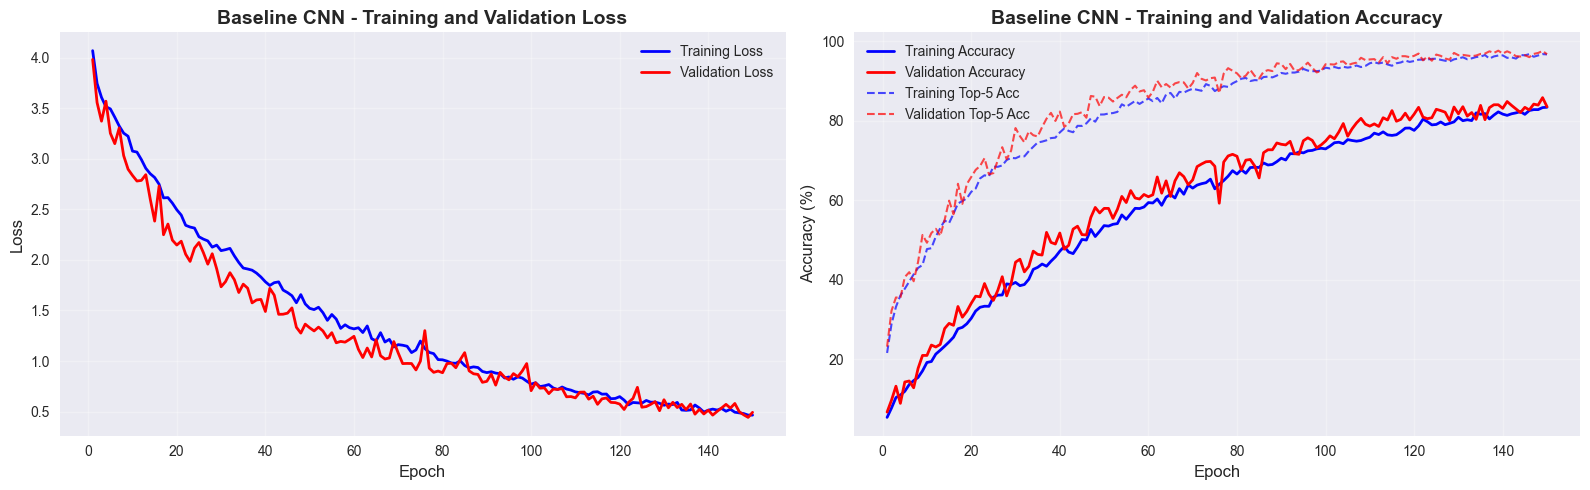

In [13]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
epochs_range = range(1, len(baseline_history['train_loss']) + 1)

# Loss plot
axes[0].plot(epochs_range, baseline_history['train_loss'], 'b-', label='Training Loss', linewidth=2)
axes[0].plot(epochs_range, baseline_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Baseline CNN - Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs_range, baseline_history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
axes[1].plot(epochs_range, baseline_history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
axes[1].plot(epochs_range, baseline_history['train_top5_acc'], 'b--', label='Training Top-5 Acc', linewidth=1.5, alpha=0.7)
axes[1].plot(epochs_range, baseline_history['val_top5_acc'], 'r--', label='Validation Top-5 Acc', linewidth=1.5, alpha=0.7)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Baseline CNN - Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
save_path = Path(BASELINE_CONFIG['figures_dir']) / 'baseline_cnn_training_curves.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"✓ Training curves saved to: {save_path}")
plt.show()

## 4. ResNet50 Training (Two-Phase)

Train ResNet50 using transfer learning with a two-phase approach:
- **Phase 1**: Train classifier head only (backbone frozen)
- **Phase 2**: Fine-tune entire network (backbone unfrozen)

In [15]:
# ResNet50 Configuration
RESNET_CONFIG = {
    **SHARED_CONFIG,
    'image_size': 224,  # Standard ImageNet size
    'model_name': 'resnet50',
    'dropout': 0.3,
    'weight_decay': 1e-4,
    'use_amp': True,
    'gradient_accumulation_steps': 2,  # Effective batch size = 16 * 2 = 32
    
    # Phase 1: Train classifier only (frozen backbone)
    'phase1': {
        'epochs': 15,
        'learning_rate': 1e-3,  # Higher LR for new layers
        'freeze_backbone': True,
        'early_stopping_patience': 5
    },
    
    # Phase 2: Fine-tune entire network
    'phase2': {
        'epochs': 35,
        'learning_rate': 1e-4,  # Lower LR for fine-tuning
        'freeze_backbone': False,
        'early_stopping_patience': 10
    },
}

print("=" * 70)
print("RESNET50 CONFIGURATION")
print("=" * 70)
print(f"  Image Size: {RESNET_CONFIG['image_size']}×{RESNET_CONFIG['image_size']}")
print(f"  Batch Size: {RESNET_CONFIG['batch_size']}")
print(f"  Effective Batch Size: {RESNET_CONFIG['batch_size'] * RESNET_CONFIG['gradient_accumulation_steps']}")
print(f"\\nPhase 1 (Classifier Training):")
print(f"  Epochs: {RESNET_CONFIG['phase1']['epochs']}")
print(f"  Learning Rate: {RESNET_CONFIG['phase1']['learning_rate']}")
print(f"  Backbone: Frozen")
print(f"\\nPhase 2 (Fine-tuning):")
print(f"  Epochs: {RESNET_CONFIG['phase2']['epochs']}")
print(f"  Learning Rate: {RESNET_CONFIG['phase2']['learning_rate']}")
print(f"  Backbone: Unfrozen")
print("=" * 70)

RESNET50 CONFIGURATION
  Image Size: 224×224
  Batch Size: 16
  Effective Batch Size: 32
\nPhase 1 (Classifier Training):
  Epochs: 15
  Learning Rate: 0.001
  Backbone: Frozen
\nPhase 2 (Fine-tuning):
  Epochs: 35
  Learning Rate: 0.0001
  Backbone: Unfrozen


In [16]:
# Create data loaders for ResNet50
print("\nCreating data loaders for ResNet50...")
resnet_loaders = create_dataloaders(
    data_dir=RESNET_CONFIG['data_dir'],
    batch_size=RESNET_CONFIG['batch_size'],
    image_size=RESNET_CONFIG['image_size'],
    num_workers=RESNET_CONFIG['num_workers'],
    use_albumentations=RESNET_CONFIG['use_albumentations'],
    use_weighted_sampler=RESNET_CONFIG['use_weighted_sampler']
)

print(f"  Training samples: {len(resnet_loaders['train'].dataset):,}")
print(f"  Validation samples: {len(resnet_loaders['val'].dataset):,}")
print(f"  Test samples: {len(resnet_loaders['test'].dataset):,}")

# Calculate class weights
if RESNET_CONFIG['use_class_weights']:
    print("\\nCalculating class weights...")
    resnet_class_weights = calculate_class_weights(resnet_loaders['train'], device)
    resnet_criterion = nn.CrossEntropyLoss(weight=resnet_class_weights)
    print(f"  Class weights calculated (min: {resnet_class_weights.min():.4f}, max: {resnet_class_weights.max():.4f})")
else:
    resnet_criterion = nn.CrossEntropyLoss()


Creating data loaders for ResNet50...
Dataset Statistics:
  Training samples: 5732
  Validation samples: 1228
  Test samples: 1229
  Number of classes: 102
  Batch size: 16
  Image size: 224x224
  Training samples: 5,732
  Validation samples: 1,228
  Test samples: 1,229
\nCalculating class weights...
  Class weights calculated (min: 0.2524, max: 1.6315)


In [17]:
# Create ResNet50 model (Phase 1: frozen backbone)
print("\\n" + "=" * 70)
print("Creating ResNet50 Model (Phase 1: Frozen Backbone)")
print("=" * 70)

resnet_model = ResNetClassifier(
    num_classes=102,
    pretrained=True,
    freeze_backbone=RESNET_CONFIG['phase1']['freeze_backbone'],
    dropout=RESNET_CONFIG['dropout']
)

# Visualize model architecture
visualize_model_architecture(resnet_model, input_size=(3, 224, 224), model_name="ResNet50")

\n======================================================================
Creating ResNet50 Model (Phase 1: Frozen Backbone)
Loaded ResNet50 with ImageNet pre-trained weights
Backbone layers frozen

ResNet50 Architecture Summary

Model architecture:
ResNetClassifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [15]:
# ========================================================================
# PHASE 1: Train Classifier Head Only (Backbone Frozen)
# ========================================================================
print("\\n" + "=" * 70)
print("PHASE 1: Training Classifier Head (Backbone Frozen)")
print("=" * 70)

# Create optimizer for Phase 1 (only trainable parameters)
resnet_phase1_optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, resnet_model.parameters()),
    lr=RESNET_CONFIG['phase1']['learning_rate'],
    weight_decay=RESNET_CONFIG['weight_decay']
)

# Learning rate scheduler for Phase 1
resnet_phase1_scheduler = ReduceLROnPlateau(
    resnet_phase1_optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=True
)

# Create trainer for Phase 1
resnet_phase1_trainer = Trainer(
    model=resnet_model,
    train_loader=resnet_loaders['train'],
    val_loader=resnet_loaders['val'],
    optimizer=resnet_phase1_optimizer,
    scheduler=resnet_phase1_scheduler,
    device=device,
    save_dir=RESNET_CONFIG['save_dir'],
    criterion=resnet_criterion,
    use_amp=RESNET_CONFIG['use_amp']
)

# Set gradient accumulation
resnet_phase1_trainer.gradient_accumulation_steps = RESNET_CONFIG['gradient_accumulation_steps']
print(f"\\nGradient Accumulation: {RESNET_CONFIG['gradient_accumulation_steps']} steps")
print(f"Effective batch size: {RESNET_CONFIG['batch_size'] * RESNET_CONFIG['gradient_accumulation_steps']}")

# Train Phase 1
print("\\nStarting Phase 1 training...")
resnet_phase1_trainer.train(
    epochs=RESNET_CONFIG['phase1']['epochs'],
    early_stopping_patience=RESNET_CONFIG['phase1']['early_stopping_patience'],
    save_best=True,
    model_name=f"{RESNET_CONFIG['model_name']}_phase1"
)

# Extract Phase 1 history
resnet_phase1_history = {
    'train_loss': resnet_phase1_trainer.history['train_loss'].copy(),
    'train_acc': resnet_phase1_trainer.history['train_acc'].copy(),
    'train_top5_acc': resnet_phase1_trainer.history['train_top5_acc'].copy(),
    'val_loss': resnet_phase1_trainer.history['val_loss'].copy(),
    'val_acc': resnet_phase1_trainer.history['val_acc'].copy(),
    'val_top5_acc': resnet_phase1_trainer.history['val_top5_acc'].copy(),
    'learning_rate': resnet_phase1_trainer.history['learning_rate'].copy()
}

print(f"\\nPhase 1 Complete!")
print(f"  Best Validation Accuracy: {max(resnet_phase1_history['val_acc']):.2f}%")
print(f"  Best Validation Top-5 Accuracy: {max(resnet_phase1_history['val_top5_acc']):.2f}%")

# Save Phase 1 metrics
save_training_metrics(resnet_phase1_history, RESNET_CONFIG['model_name'], RESNET_CONFIG['metrics_dir'], phase='phase1')

d:\MSc Islington\Computer Vision\Deep-Learning-Based-Plant-Species-Classification-Using-Leaf-and-Flower-Images\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


\n======================================================================
PHASE 1: Training Classifier Head (Backbone Frozen)
Using device: cuda
\nGradient Accumulation: 2 steps
Effective batch size: 32
\nStarting Phase 1 training...

Starting training for 15 epochs...
Training samples: 5732
Validation samples: 1228
------------------------------------------------------------


Epoch [1/15] - 56.1s
  Train Loss: 3.0388 | Train Acc: 29.49% | Train Top-5: 50.49%
  Val Loss: 1.4315 | Val Acc: 56.84% | Val Top-5: 82.00%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 56.84%)
------------------------------------------------------------


Epoch [2/15] - 53.1s
  Train Loss: 1.1180 | Train Acc: 67.60% | Train Top-5: 89.63%
  Val Loss: 0.7666 | Val Acc: 75.81% | Val Top-5: 94.06%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 75.81%)
------------------------------------------------------------


Epoch [3/15] - 50.5s
  Train Loss: 0.7292 | Train Acc: 78.14% | Train Top-5: 94.36%
  Val Loss: 0.5734 | Val Acc: 82.08% | Val Top-5: 95.28%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 82.08%)
------------------------------------------------------------


Epoch [4/15] - 49.3s
  Train Loss: 0.6016 | Train Acc: 80.92% | Train Top-5: 95.83%
  Val Loss: 0.4505 | Val Acc: 85.99% | Val Top-5: 97.31%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 85.99%)
------------------------------------------------------------


Epoch [5/15] - 51.3s
  Train Loss: 0.5183 | Train Acc: 83.31% | Train Top-5: 96.58%
  Val Loss: 0.3892 | Val Acc: 86.97% | Val Top-5: 97.39%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 86.97%)
------------------------------------------------------------


Epoch [6/15] - 60.4s
  Train Loss: 0.4508 | Train Acc: 85.91% | Train Top-5: 97.19%
  Val Loss: 0.3323 | Val Acc: 88.60% | Val Top-5: 98.62%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 88.60%)
------------------------------------------------------------


Epoch [7/15] - 59.3s
  Train Loss: 0.3911 | Train Acc: 87.17% | Train Top-5: 97.63%
  Val Loss: 0.2904 | Val Acc: 90.64% | Val Top-5: 98.45%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 90.64%)
------------------------------------------------------------


Epoch [8/15] - 55.8s
  Train Loss: 0.3786 | Train Acc: 87.40% | Train Top-5: 97.82%
  Val Loss: 0.3212 | Val Acc: 90.23% | Val Top-5: 98.45%
  Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch [9/15] - 62.0s
  Train Loss: 0.3354 | Train Acc: 88.46% | Train Top-5: 98.11%
  Val Loss: 0.2572 | Val Acc: 91.12% | Val Top-5: 98.94%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 91.12%)
------------------------------------------------------------


Epoch [10/15] - 55.5s
  Train Loss: 0.3053 | Train Acc: 89.49% | Train Top-5: 98.50%
  Val Loss: 0.2730 | Val Acc: 90.64% | Val Top-5: 98.70%
  Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch [11/15] - 52.9s
  Train Loss: 0.2771 | Train Acc: 91.03% | Train Top-5: 98.57%
  Val Loss: 0.2662 | Val Acc: 91.04% | Val Top-5: 99.10%
  Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch [12/15] - 50.6s
  Train Loss: 0.2857 | Train Acc: 90.33% | Train Top-5: 98.39%
  Val Loss: 0.2449 | Val Acc: 92.10% | Val Top-5: 98.78%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 92.10%)
------------------------------------------------------------


Epoch [13/15] - 50.0s
  Train Loss: 0.2696 | Train Acc: 90.87% | Train Top-5: 98.64%
  Val Loss: 0.2420 | Val Acc: 92.10% | Val Top-5: 98.86%
  Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch [14/15] - 49.9s
  Train Loss: 0.2625 | Train Acc: 90.61% | Train Top-5: 98.90%
  Val Loss: 0.2434 | Val Acc: 92.18% | Val Top-5: 98.70%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 92.18%)
------------------------------------------------------------


Epoch [15/15] - 51.4s
  Train Loss: 0.2533 | Train Acc: 91.29% | Train Top-5: 98.62%
  Val Loss: 0.2235 | Val Acc: 93.00% | Val Top-5: 99.27%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 93.00%)
------------------------------------------------------------

Training completed in 13.5 minutes
Best Validation Accuracy: 93.00%
\nPhase 1 Complete!
  Best Validation Accuracy: 93.00%
  Best Validation Top-5 Accuracy: 99.27%
✓ Training metrics saved to: results\metrics\resnet50_phase1_training_metrics.txt


In [16]:
# ========================================================================
# PHASE 2: Fine-tune Entire Network
# ========================================================================
print("\\n" + "=" * 70)
print("PHASE 2: Fine-tuning Entire Network")
print("=" * 70)

# Unfreeze backbone for fine-tuning
print("\\nUnfreezing backbone layers...")
resnet_model.unfreeze_backbone(unfreeze_from_layer=0)

trainable_params = sum(p.numel() for p in resnet_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in resnet_model.parameters())
print(f"  Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")

# Create optimizer for Phase 2 with different learning rates for backbone and classifier
backbone_params = []
classifier_params = []

for name, param in resnet_model.named_parameters():
    if param.requires_grad:
        if 'backbone' in name:
            backbone_params.append(param)
        else:
            classifier_params.append(param)

# Use lower LR for backbone, slightly higher for classifier
resnet_phase2_optimizer = optim.Adam(
    [
        {'params': backbone_params, 'lr': RESNET_CONFIG['phase2']['learning_rate']},
        {'params': classifier_params, 'lr': RESNET_CONFIG['phase2']['learning_rate'] * 2}
    ],
    weight_decay=RESNET_CONFIG['weight_decay']
)

print(f"  Backbone learning rate: {RESNET_CONFIG['phase2']['learning_rate']}")
print(f"  Classifier learning rate: {RESNET_CONFIG['phase2']['learning_rate'] * 2}")

# New scheduler for Phase 2
resnet_phase2_scheduler = ReduceLROnPlateau(
    resnet_phase2_optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=True
)

# Update trainer with new optimizer and scheduler
resnet_phase1_trainer.optimizer = resnet_phase2_optimizer
resnet_phase1_trainer.scheduler = resnet_phase2_scheduler
resnet_phase1_trainer.best_val_acc = max(resnet_phase1_history['val_acc'])  # Continue from phase 1 best
resnet_phase1_trainer.gradient_accumulation_steps = RESNET_CONFIG['gradient_accumulation_steps']

# Train Phase 2
print("\\nStarting Phase 2 training...")
resnet_phase1_trainer.train(
    epochs=RESNET_CONFIG['phase2']['epochs'],
    early_stopping_patience=RESNET_CONFIG['phase2']['early_stopping_patience'],
    save_best=True,
    model_name=RESNET_CONFIG['model_name']
)

# Extract Phase 2 history (only new entries)
phase1_len = len(resnet_phase1_history['train_loss'])
resnet_phase2_history = {
    'train_loss': resnet_phase1_trainer.history['train_loss'][phase1_len:],
    'train_acc': resnet_phase1_trainer.history['train_acc'][phase1_len:],
    'train_top5_acc': resnet_phase1_trainer.history['train_top5_acc'][phase1_len:],
    'val_loss': resnet_phase1_trainer.history['val_loss'][phase1_len:],
    'val_acc': resnet_phase1_trainer.history['val_acc'][phase1_len:],
    'val_top5_acc': resnet_phase1_trainer.history['val_top5_acc'][phase1_len:],
    'learning_rate': resnet_phase1_trainer.history['learning_rate'][phase1_len:]
}

# Combined history (full training history)
resnet_combined_history = resnet_phase1_trainer.history.copy()

print(f"\\nPhase 2 Complete!")
print(f"  Best Validation Accuracy: {max(resnet_phase2_history['val_acc']):.2f}%")
print(f"  Best Validation Top-5 Accuracy: {max(resnet_phase2_history['val_top5_acc']):.2f}%")

print("\\n" + "=" * 70)
print("RESNET50 TRAINING COMPLETE!")
print("=" * 70)
print(f"Overall Best Validation Accuracy: {max(resnet_combined_history['val_acc']):.2f}%")
print(f"Overall Best Validation Top-5 Accuracy: {max(resnet_combined_history['val_top5_acc']):.2f}%")
print(f"Final Validation Accuracy: {resnet_combined_history['val_acc'][-1]:.2f}%")
print("=" * 70)

# Save Phase 2 and combined metrics
save_training_metrics(resnet_phase2_history, RESNET_CONFIG['model_name'], RESNET_CONFIG['metrics_dir'], phase='phase2')
save_training_metrics(resnet_combined_history, RESNET_CONFIG['model_name'], RESNET_CONFIG['metrics_dir'], phase=None)

\n======================================================================
PHASE 2: Fine-tuning Entire Network
\nUnfreezing backbone layers...
Unfroze backbone from layer 0
Trainable backbone params: 23,508,032 / 23,508,032
  Trainable parameters: 24,609,446 (100.00%)
  Backbone learning rate: 0.0001
  Classifier learning rate: 0.0002
\nStarting Phase 2 training...

Starting training for 35 epochs...
Training samples: 5732
Validation samples: 1228
------------------------------------------------------------


Epoch [1/35] - 86.2s
  Train Loss: 0.1473 | Train Acc: 94.50% | Train Top-5: 99.48%
  Val Loss: 0.1540 | Val Acc: 95.68% | Val Top-5: 99.59%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 95.68%)
------------------------------------------------------------


Epoch [2/35] - 84.3s
  Train Loss: 0.1177 | Train Acc: 95.36% | Train Top-5: 99.69%
  Val Loss: 0.1420 | Val Acc: 94.63% | Val Top-5: 99.67%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [3/35] - 85.3s
  Train Loss: 0.0973 | Train Acc: 96.42% | Train Top-5: 99.76%
  Val Loss: 0.1206 | Val Acc: 96.50% | Val Top-5: 99.84%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 96.50%)
------------------------------------------------------------


Epoch [4/35] - 84.7s
  Train Loss: 0.0800 | Train Acc: 96.82% | Train Top-5: 99.81%
  Val Loss: 0.1048 | Val Acc: 96.66% | Val Top-5: 99.92%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 96.66%)
------------------------------------------------------------


Epoch [5/35] - 83.1s
  Train Loss: 0.0665 | Train Acc: 97.64% | Train Top-5: 99.77%
  Val Loss: 0.1047 | Val Acc: 96.91% | Val Top-5: 99.84%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 96.91%)
------------------------------------------------------------


Epoch [6/35] - 83.3s
  Train Loss: 0.0560 | Train Acc: 97.84% | Train Top-5: 99.79%
  Val Loss: 0.1065 | Val Acc: 96.74% | Val Top-5: 99.76%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [7/35] - 83.2s
  Train Loss: 0.0504 | Train Acc: 98.04% | Train Top-5: 99.79%
  Val Loss: 0.0983 | Val Acc: 97.07% | Val Top-5: 99.92%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 97.07%)
------------------------------------------------------------


Epoch [8/35] - 83.1s
  Train Loss: 0.0532 | Train Acc: 98.01% | Train Top-5: 99.83%
  Val Loss: 0.0948 | Val Acc: 97.96% | Val Top-5: 99.76%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 97.96%)
------------------------------------------------------------


Epoch [9/35] - 83.0s
  Train Loss: 0.0452 | Train Acc: 98.22% | Train Top-5: 99.91%
  Val Loss: 0.1061 | Val Acc: 97.96% | Val Top-5: 99.84%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [10/35] - 83.0s
  Train Loss: 0.0456 | Train Acc: 98.31% | Train Top-5: 99.86%
  Val Loss: 0.0766 | Val Acc: 97.88% | Val Top-5: 99.84%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [11/35] - 83.0s
  Train Loss: 0.0596 | Train Acc: 97.94% | Train Top-5: 99.74%
  Val Loss: 0.0894 | Val Acc: 97.72% | Val Top-5: 99.76%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [12/35] - 82.8s
  Train Loss: 0.0466 | Train Acc: 98.18% | Train Top-5: 99.86%
  Val Loss: 0.0848 | Val Acc: 97.72% | Val Top-5: 99.92%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [13/35] - 83.3s
  Train Loss: 0.0437 | Train Acc: 98.15% | Train Top-5: 99.95%
  Val Loss: 0.1053 | Val Acc: 97.64% | Val Top-5: 99.76%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [14/35] - 82.9s
  Train Loss: 0.0412 | Train Acc: 98.45% | Train Top-5: 99.91%
  Val Loss: 0.1218 | Val Acc: 97.15% | Val Top-5: 99.84%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [15/35] - 83.0s
  Train Loss: 0.0446 | Train Acc: 98.38% | Train Top-5: 99.88%
  Val Loss: 0.1036 | Val Acc: 97.56% | Val Top-5: 99.84%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [16/35] - 83.1s
  Train Loss: 0.0320 | Train Acc: 98.97% | Train Top-5: 99.91%
  Val Loss: 0.0976 | Val Acc: 98.05% | Val Top-5: 99.84%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 98.05%)
------------------------------------------------------------


Epoch [17/35] - 83.1s
  Train Loss: 0.0285 | Train Acc: 99.02% | Train Top-5: 99.98%
  Val Loss: 0.0842 | Val Acc: 98.13% | Val Top-5: 99.76%
  Learning Rate: 5.00e-05
  [OK] New best model saved! (Val Acc: 98.13%)
------------------------------------------------------------


Epoch [18/35] - 83.2s
  Train Loss: 0.0287 | Train Acc: 99.06% | Train Top-5: 99.93%
  Val Loss: 0.0835 | Val Acc: 98.29% | Val Top-5: 99.84%
  Learning Rate: 5.00e-05
  [OK] New best model saved! (Val Acc: 98.29%)
------------------------------------------------------------


Epoch [19/35] - 83.2s
  Train Loss: 0.0179 | Train Acc: 99.32% | Train Top-5: 99.98%
  Val Loss: 0.0972 | Val Acc: 98.53% | Val Top-5: 99.76%
  Learning Rate: 5.00e-05
  [OK] New best model saved! (Val Acc: 98.53%)
------------------------------------------------------------


Epoch [20/35] - 83.0s
  Train Loss: 0.0145 | Train Acc: 99.42% | Train Top-5: 100.00%
  Val Loss: 0.0917 | Val Acc: 98.53% | Val Top-5: 99.76%
  Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch [21/35] - 83.0s
  Train Loss: 0.0260 | Train Acc: 98.97% | Train Top-5: 99.98%
  Val Loss: 0.0909 | Val Acc: 98.53% | Val Top-5: 99.67%
  Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch [22/35] - 82.7s
  Train Loss: 0.0169 | Train Acc: 99.34% | Train Top-5: 99.98%
  Val Loss: 0.0861 | Val Acc: 98.45% | Val Top-5: 99.84%
  Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch [23/35] - 82.9s
  Train Loss: 0.0195 | Train Acc: 99.35% | Train Top-5: 99.98%
  Val Loss: 0.0819 | Val Acc: 98.45% | Val Top-5: 99.76%
  Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch [24/35] - 82.9s
  Train Loss: 0.0189 | Train Acc: 99.30% | Train Top-5: 99.97%
  Val Loss: 0.0840 | Val Acc: 98.53% | Val Top-5: 99.76%
  Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch [25/35] - 83.0s
  Train Loss: 0.0155 | Train Acc: 99.49% | Train Top-5: 99.97%
  Val Loss: 0.0695 | Val Acc: 98.53% | Val Top-5: 99.76%
  Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch [26/35] - 83.1s
  Train Loss: 0.0115 | Train Acc: 99.65% | Train Top-5: 99.98%
  Val Loss: 0.0809 | Val Acc: 98.53% | Val Top-5: 99.84%
  Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch [27/35] - 83.5s
  Train Loss: 0.0190 | Train Acc: 99.35% | Train Top-5: 99.97%
  Val Loss: 0.0902 | Val Acc: 98.45% | Val Top-5: 99.84%
  Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch [28/35] - 83.0s
  Train Loss: 0.0116 | Train Acc: 99.55% | Train Top-5: 100.00%
  Val Loss: 0.0767 | Val Acc: 98.29% | Val Top-5: 99.84%
  Learning Rate: 2.50e-05
------------------------------------------------------------


Epoch [29/35] - 83.1s
  Train Loss: 0.0092 | Train Acc: 99.62% | Train Top-5: 99.98%
  Val Loss: 0.0774 | Val Acc: 98.37% | Val Top-5: 99.84%
  Learning Rate: 2.50e-05

Early stopping triggered after 29 epochs

Training completed in 40.3 minutes
Best Validation Accuracy: 98.53%
\nPhase 2 Complete!
  Best Validation Accuracy: 98.53%
  Best Validation Top-5 Accuracy: 99.92%
\n======================================================================
RESNET50 TRAINING COMPLETE!
Overall Best Validation Accuracy: 98.53%
Overall Best Validation Top-5 Accuracy: 99.92%
Final Validation Accuracy: 98.37%
✓ Training metrics saved to: results\metrics\resnet50_phase2_training_metrics.txt
✓ Training metrics saved to: results\metrics\resnet50_training_metrics.txt


Loading ResNet50 training metrics...
✓ Loaded training metrics from: results\metrics\resnet50_training_metrics.txt (44 epochs)
✓ Training curves saved to: results\figures\resnet50_training_curves.png


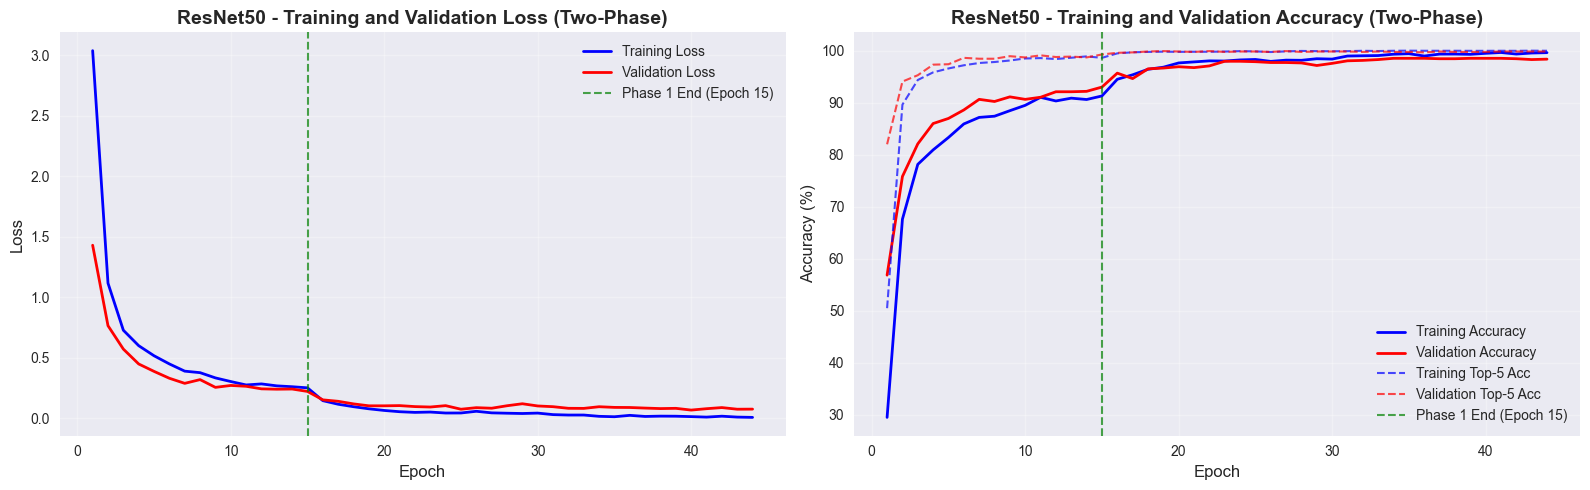

In [ ]:
# Load ResNet50 training metrics from saved file (combined history)
print("Loading ResNet50 training metrics...")
resnet_combined_history = load_training_metrics(
    'resnet50',  # model_name
    'results/metrics',  # metrics_dir
    phase=None
)

# Visualize ResNet50 training history (combined)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
epochs_range = range(1, len(resnet_combined_history['train_loss']) + 1)
phase1_epochs = 15  # Phase 1 epochs for ResNet50

# Loss plot
axes[0].plot(epochs_range, resnet_combined_history['train_loss'], 'b-', label='Training Loss', linewidth=2)
axes[0].plot(epochs_range, resnet_combined_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0].axvline(x=phase1_epochs, color='g', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Phase 1 End (Epoch {phase1_epochs})')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('ResNet50 - Training and Validation Loss (Two-Phase)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs_range, resnet_combined_history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
axes[1].plot(epochs_range, resnet_combined_history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
axes[1].plot(epochs_range, resnet_combined_history['train_top5_acc'], 'b--', label='Training Top-5 Acc', linewidth=1.5, alpha=0.7)
axes[1].plot(epochs_range, resnet_combined_history['val_top5_acc'], 'r--', label='Validation Top-5 Acc', linewidth=1.5, alpha=0.7)
axes[1].axvline(x=phase1_epochs, color='g', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Phase 1 End (Epoch {phase1_epochs})')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('ResNet50 - Training and Validation Accuracy (Two-Phase)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
save_path = Path(RESNET_CONFIG['figures_dir']) / 'resnet50_training_curves.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"✓ Training curves saved to: {save_path}")
plt.show()

## 5. EfficientNet-B3 Training

Train EfficientNet-B3 using transfer learning with a two-phase approach similar to ResNet50.

In [7]:
# EfficientNet-B3 Configuration
EFFICIENTNET_CONFIG = {
    **SHARED_CONFIG,
    'image_size': 300,  # EfficientNet-B3 recommended input size
    'model_name': 'efficientnet_b3',
    'model_variant': 'efficientnet_b3',
    'dropout': 0.3,
    'weight_decay': 1e-4,
    'use_amp': True,
    'gradient_accumulation_steps': 2,  # Effective batch size = 16 * 2 = 32
    
    # Phase 1: Train classifier only (frozen backbone)
    'phase1': {
        'epochs': 15,
        'learning_rate': 1e-3,  # Higher LR for new layers
        'freeze_backbone': True,
        'early_stopping_patience': 5
    },
    
    # Phase 2: Fine-tune entire network
    'phase2': {
        'epochs': 35,
        'learning_rate': 1e-4,  # Lower LR for fine-tuning
        'freeze_backbone': False,
        'early_stopping_patience': 10
    },
}

print("=" * 70)
print("EFFICIENTNET-B3 CONFIGURATION")
print("=" * 70)
print(f"  Model Variant: {EFFICIENTNET_CONFIG['model_variant']}")
print(f"  Image Size: {EFFICIENTNET_CONFIG['image_size']}×{EFFICIENTNET_CONFIG['image_size']}")
print(f"  Batch Size: {EFFICIENTNET_CONFIG['batch_size']}")
print(f"  Effective Batch Size: {EFFICIENTNET_CONFIG['batch_size'] * EFFICIENTNET_CONFIG['gradient_accumulation_steps']}")
print(f"\\nPhase 1 (Classifier Training):")
print(f"  Epochs: {EFFICIENTNET_CONFIG['phase1']['epochs']}")
print(f"  Learning Rate: {EFFICIENTNET_CONFIG['phase1']['learning_rate']}")
print(f"  Backbone: Frozen")
print(f"\\nPhase 2 (Fine-tuning):")
print(f"  Epochs: {EFFICIENTNET_CONFIG['phase2']['epochs']}")
print(f"  Learning Rate: {EFFICIENTNET_CONFIG['phase2']['learning_rate']}")
print(f"  Backbone: Unfrozen")
print("=" * 70)

EFFICIENTNET-B3 CONFIGURATION
  Model Variant: efficientnet_b3
  Image Size: 300×300
  Batch Size: 16
  Effective Batch Size: 32
\nPhase 1 (Classifier Training):
  Epochs: 15
  Learning Rate: 0.001
  Backbone: Frozen
\nPhase 2 (Fine-tuning):
  Epochs: 35
  Learning Rate: 0.0001
  Backbone: Unfrozen


In [8]:
# Create data loaders for EfficientNet-B3 (uses 300x300 input size)
print("\nCreating data loaders for EfficientNet-B3...")
efficientnet_loaders = create_dataloaders(
    data_dir=EFFICIENTNET_CONFIG['data_dir'],
    batch_size=EFFICIENTNET_CONFIG['batch_size'],
    image_size=EFFICIENTNET_CONFIG['image_size'],
    num_workers=EFFICIENTNET_CONFIG['num_workers'],
    use_albumentations=EFFICIENTNET_CONFIG['use_albumentations'],
    use_weighted_sampler=EFFICIENTNET_CONFIG['use_weighted_sampler']
)

print(f"  Training samples: {len(efficientnet_loaders['train'].dataset):,}")
print(f"  Validation samples: {len(efficientnet_loaders['val'].dataset):,}")
print(f"  Test samples: {len(efficientnet_loaders['test'].dataset):,}")

# Calculate class weights
if EFFICIENTNET_CONFIG['use_class_weights']:
    print("\\nCalculating class weights...")
    efficientnet_class_weights = calculate_class_weights(efficientnet_loaders['train'], device)
    efficientnet_criterion = nn.CrossEntropyLoss(weight=efficientnet_class_weights)
    print(f"  Class weights calculated (min: {efficientnet_class_weights.min():.4f}, max: {efficientnet_class_weights.max():.4f})")
else:
    efficientnet_criterion = nn.CrossEntropyLoss()


Creating data loaders for EfficientNet-B3...
Dataset Statistics:
  Training samples: 5732
  Validation samples: 1228
  Test samples: 1229
  Number of classes: 102
  Batch size: 16
  Image size: 300x300
  Training samples: 5,732
  Validation samples: 1,228
  Test samples: 1,229
\nCalculating class weights...
  Class weights calculated (min: 0.2524, max: 1.6315)


In [9]:
# Create EfficientNet-B3 model (Phase 1: frozen backbone)
print("\\n" + "=" * 70)
print("Creating EfficientNet-B3 Model (Phase 1: Frozen Backbone)")
print("=" * 70)

efficientnet_model = EfficientNetClassifier(
    num_classes=102,
    model_name=EFFICIENTNET_CONFIG['model_variant'],
    pretrained=True,
    freeze_backbone=EFFICIENTNET_CONFIG['phase1']['freeze_backbone'],
    dropout=EFFICIENTNET_CONFIG['dropout']
)

# Visualize model architecture
visualize_model_architecture(efficientnet_model, input_size=(3, 300, 300), model_name="EfficientNet-B3")

\n======================================================================
Creating EfficientNet-B3 Model (Phase 1: Frozen Backbone)
Loaded efficientnet_b3 with ImageNet pre-trained weights
Backbone output features: 1536
Backbone layers frozen

EfficientNet-B3 Architecture Summary

Model architecture:
EfficientNetClassifier(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
 

In [10]:
# ========================================================================
# PHASE 1: Train Classifier Head Only (Backbone Frozen)
# ========================================================================
print("\\n" + "=" * 70)
print("PHASE 1: Training Classifier Head (Backbone Frozen)")
print("=" * 70)

# Create optimizer for Phase 1 (only trainable parameters)
efficientnet_phase1_optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, efficientnet_model.parameters()),
    lr=EFFICIENTNET_CONFIG['phase1']['learning_rate'],
    weight_decay=EFFICIENTNET_CONFIG['weight_decay']
)

# Learning rate scheduler for Phase 1
efficientnet_phase1_scheduler = ReduceLROnPlateau(
    efficientnet_phase1_optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=True
)

# Create trainer for Phase 1
efficientnet_phase1_trainer = Trainer(
    model=efficientnet_model,
    train_loader=efficientnet_loaders['train'],
    val_loader=efficientnet_loaders['val'],
    optimizer=efficientnet_phase1_optimizer,
    scheduler=efficientnet_phase1_scheduler,
    device=device,
    save_dir=EFFICIENTNET_CONFIG['save_dir'],
    criterion=efficientnet_criterion,
    use_amp=EFFICIENTNET_CONFIG['use_amp']
)

# Set gradient accumulation
efficientnet_phase1_trainer.gradient_accumulation_steps = EFFICIENTNET_CONFIG['gradient_accumulation_steps']
print(f"\\nGradient Accumulation: {EFFICIENTNET_CONFIG['gradient_accumulation_steps']} steps")
print(f"Effective batch size: {EFFICIENTNET_CONFIG['batch_size'] * EFFICIENTNET_CONFIG['gradient_accumulation_steps']}")

# Train Phase 1
print("\\nStarting Phase 1 training...")
efficientnet_phase1_trainer.train(
    epochs=EFFICIENTNET_CONFIG['phase1']['epochs'],
    early_stopping_patience=EFFICIENTNET_CONFIG['phase1']['early_stopping_patience'],
    save_best=True,
    model_name=f"{EFFICIENTNET_CONFIG['model_name']}_phase1"
)

# Extract Phase 1 history
efficientnet_phase1_history = {
    'train_loss': efficientnet_phase1_trainer.history['train_loss'].copy(),
    'train_acc': efficientnet_phase1_trainer.history['train_acc'].copy(),
    'train_top5_acc': efficientnet_phase1_trainer.history['train_top5_acc'].copy(),
    'val_loss': efficientnet_phase1_trainer.history['val_loss'].copy(),
    'val_acc': efficientnet_phase1_trainer.history['val_acc'].copy(),
    'val_top5_acc': efficientnet_phase1_trainer.history['val_top5_acc'].copy(),
    'learning_rate': efficientnet_phase1_trainer.history['learning_rate'].copy()
}

print(f"\\nPhase 1 Complete!")
print(f"  Best Validation Accuracy: {max(efficientnet_phase1_history['val_acc']):.2f}%")
print(f"  Best Validation Top-5 Accuracy: {max(efficientnet_phase1_history['val_top5_acc']):.2f}%")

# Save Phase 1 metrics
save_training_metrics(efficientnet_phase1_history, EFFICIENTNET_CONFIG['model_name'], EFFICIENTNET_CONFIG['metrics_dir'], phase='phase1')

d:\MSc Islington\Computer Vision\Deep-Learning-Based-Plant-Species-Classification-Using-Leaf-and-Flower-Images\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


\n======================================================================
PHASE 1: Training Classifier Head (Backbone Frozen)
Using device: cuda
\nGradient Accumulation: 2 steps
Effective batch size: 32
\nStarting Phase 1 training...

Starting training for 15 epochs...
Training samples: 5732
Validation samples: 1228
------------------------------------------------------------


Epoch [1/15] - 80.9s
  Train Loss: 3.1021 | Train Acc: 27.27% | Train Top-5: 50.47%
  Val Loss: 1.6678 | Val Acc: 54.64% | Val Top-5: 79.23%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 54.64%)
------------------------------------------------------------


Epoch [2/15] - 75.1s
  Train Loss: 1.2496 | Train Acc: 63.98% | Train Top-5: 88.04%
  Val Loss: 0.8502 | Val Acc: 74.84% | Val Top-5: 94.14%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 74.84%)
------------------------------------------------------------


Epoch [3/15] - 74.8s
  Train Loss: 0.8649 | Train Acc: 73.06% | Train Top-5: 93.09%
  Val Loss: 0.6678 | Val Acc: 81.43% | Val Top-5: 95.20%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 81.43%)
------------------------------------------------------------


Epoch [4/15] - 72.6s
  Train Loss: 0.6756 | Train Acc: 78.25% | Train Top-5: 95.18%
  Val Loss: 0.5427 | Val Acc: 84.36% | Val Top-5: 96.82%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 84.36%)
------------------------------------------------------------


Epoch [5/15] - 69.8s
  Train Loss: 0.5823 | Train Acc: 81.30% | Train Top-5: 96.16%
  Val Loss: 0.4382 | Val Acc: 86.89% | Val Top-5: 97.48%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 86.89%)
------------------------------------------------------------


Epoch [6/15] - 69.8s
  Train Loss: 0.5232 | Train Acc: 81.88% | Train Top-5: 96.63%
  Val Loss: 0.4054 | Val Acc: 87.38% | Val Top-5: 98.21%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 87.38%)
------------------------------------------------------------


Epoch [7/15] - 71.1s
  Train Loss: 0.4570 | Train Acc: 84.58% | Train Top-5: 97.12%
  Val Loss: 0.3690 | Val Acc: 88.68% | Val Top-5: 98.62%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 88.68%)
------------------------------------------------------------


Epoch [8/15] - 70.4s
  Train Loss: 0.4378 | Train Acc: 84.57% | Train Top-5: 97.64%
  Val Loss: 0.3569 | Val Acc: 89.09% | Val Top-5: 97.72%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 89.09%)
------------------------------------------------------------


Epoch [9/15] - 70.5s
  Train Loss: 0.3895 | Train Acc: 86.91% | Train Top-5: 97.84%
  Val Loss: 0.3090 | Val Acc: 90.55% | Val Top-5: 98.86%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 90.55%)
------------------------------------------------------------


Epoch [10/15] - 71.0s
  Train Loss: 0.3703 | Train Acc: 87.40% | Train Top-5: 97.94%
  Val Loss: 0.3239 | Val Acc: 89.58% | Val Top-5: 97.96%
  Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch [11/15] - 70.7s
  Train Loss: 0.3498 | Train Acc: 87.80% | Train Top-5: 98.29%
  Val Loss: 0.3068 | Val Acc: 91.37% | Val Top-5: 98.70%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 91.37%)
------------------------------------------------------------


Epoch [12/15] - 70.3s
  Train Loss: 0.3201 | Train Acc: 88.41% | Train Top-5: 98.27%
  Val Loss: 0.3089 | Val Acc: 91.12% | Val Top-5: 98.45%
  Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch [13/15] - 70.2s
  Train Loss: 0.3122 | Train Acc: 89.19% | Train Top-5: 98.29%
  Val Loss: 0.2967 | Val Acc: 90.96% | Val Top-5: 98.94%
  Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch [14/15] - 97.5s
  Train Loss: 0.3060 | Train Acc: 89.33% | Train Top-5: 98.25%
  Val Loss: 0.2626 | Val Acc: 91.21% | Val Top-5: 99.19%
  Learning Rate: 1.00e-03
------------------------------------------------------------


Epoch [15/15] - 106.5s
  Train Loss: 0.2771 | Train Acc: 89.94% | Train Top-5: 98.64%
  Val Loss: 0.2628 | Val Acc: 92.26% | Val Top-5: 98.70%
  Learning Rate: 1.00e-03
  [OK] New best model saved! (Val Acc: 92.26%)
------------------------------------------------------------

Training completed in 19.0 minutes
Best Validation Accuracy: 92.26%
\nPhase 1 Complete!
  Best Validation Accuracy: 92.26%
  Best Validation Top-5 Accuracy: 99.19%
✓ Training metrics saved to: results\metrics\efficientnet_b3_phase1_training_metrics.txt


In [11]:
# ========================================================================
# PHASE 2: Fine-tune Entire Network
# ========================================================================
print("\\n" + "=" * 70)
print("PHASE 2: Fine-tuning Entire Network")
print("=" * 70)

# Unfreeze backbone for fine-tuning
print("\\nUnfreezing backbone layers...")
efficientnet_model.unfreeze_backbone(unfreeze_ratio=1.0)

trainable_params = sum(p.numel() for p in efficientnet_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in efficientnet_model.parameters())
print(f"  Trainable parameters: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")

# Create optimizer for Phase 2
efficientnet_phase2_optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, efficientnet_model.parameters()),
    lr=EFFICIENTNET_CONFIG['phase2']['learning_rate'],
    weight_decay=EFFICIENTNET_CONFIG['weight_decay']
)

print(f"  Learning rate: {EFFICIENTNET_CONFIG['phase2']['learning_rate']}")

# New scheduler for Phase 2
efficientnet_phase2_scheduler = ReduceLROnPlateau(
    efficientnet_phase2_optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=True
)

# Update trainer with new optimizer and scheduler
efficientnet_phase1_trainer.optimizer = efficientnet_phase2_optimizer
efficientnet_phase1_trainer.scheduler = efficientnet_phase2_scheduler
efficientnet_phase1_trainer.best_val_acc = max(efficientnet_phase1_history['val_acc'])  # Continue from phase 1 best
efficientnet_phase1_trainer.gradient_accumulation_steps = EFFICIENTNET_CONFIG['gradient_accumulation_steps']

# Train Phase 2
print("\\nStarting Phase 2 training...")
efficientnet_phase1_trainer.train(
    epochs=EFFICIENTNET_CONFIG['phase2']['epochs'],
    early_stopping_patience=EFFICIENTNET_CONFIG['phase2']['early_stopping_patience'],
    save_best=True,
    model_name=EFFICIENTNET_CONFIG['model_name']
)

# Extract Phase 2 history (only new entries)
phase1_len = len(efficientnet_phase1_history['train_loss'])
efficientnet_phase2_history = {
    'train_loss': efficientnet_phase1_trainer.history['train_loss'][phase1_len:],
    'train_acc': efficientnet_phase1_trainer.history['train_acc'][phase1_len:],
    'train_top5_acc': efficientnet_phase1_trainer.history['train_top5_acc'][phase1_len:],
    'val_loss': efficientnet_phase1_trainer.history['val_loss'][phase1_len:],
    'val_acc': efficientnet_phase1_trainer.history['val_acc'][phase1_len:],
    'val_top5_acc': efficientnet_phase1_trainer.history['val_top5_acc'][phase1_len:],
    'learning_rate': efficientnet_phase1_trainer.history['learning_rate'][phase1_len:]
}

# Combined history (full training history)
efficientnet_combined_history = efficientnet_phase1_trainer.history.copy()

print(f"\\nPhase 2 Complete!")
print(f"  Best Validation Accuracy: {max(efficientnet_phase2_history['val_acc']):.2f}%")
print(f"  Best Validation Top-5 Accuracy: {max(efficientnet_phase2_history['val_top5_acc']):.2f}%")

print("\\n" + "=" * 70)
print("EFFICIENTNET-B3 TRAINING COMPLETE!")
print("=" * 70)
print(f"Overall Best Validation Accuracy: {max(efficientnet_combined_history['val_acc']):.2f}%")
print(f"Overall Best Validation Top-5 Accuracy: {max(efficientnet_combined_history['val_top5_acc']):.2f}%")
print(f"Final Validation Accuracy: {efficientnet_combined_history['val_acc'][-1]:.2f}%")
print("=" * 70)

# Save Phase 2 and combined metrics
save_training_metrics(efficientnet_phase2_history, EFFICIENTNET_CONFIG['model_name'], EFFICIENTNET_CONFIG['metrics_dir'], phase='phase2')
save_training_metrics(efficientnet_combined_history, EFFICIENTNET_CONFIG['model_name'], EFFICIENTNET_CONFIG['metrics_dir'], phase=None)

\n======================================================================
PHASE 2: Fine-tuning Entire Network
\nUnfreezing backbone layers...
Unfroze 100% of backbone
Trainable backbone params: 10,696,232
  Trainable parameters: 11,115,918 (100.00%)
  Learning rate: 0.0001
\nStarting Phase 2 training...

Starting training for 35 epochs...
Training samples: 5732
Validation samples: 1228
------------------------------------------------------------


Epoch [1/35] - 151.9s
  Train Loss: 0.1881 | Train Acc: 92.81% | Train Top-5: 99.23%
  Val Loss: 0.1401 | Val Acc: 96.25% | Val Top-5: 99.43%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 96.25%)
------------------------------------------------------------


Epoch [2/35] - 147.2s
  Train Loss: 0.1194 | Train Acc: 95.25% | Train Top-5: 99.60%
  Val Loss: 0.1089 | Val Acc: 97.23% | Val Top-5: 99.76%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 97.23%)
------------------------------------------------------------


Epoch [3/35] - 148.0s
  Train Loss: 0.0991 | Train Acc: 95.93% | Train Top-5: 99.69%
  Val Loss: 0.1056 | Val Acc: 96.99% | Val Top-5: 99.84%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [4/35] - 143.0s
  Train Loss: 0.0796 | Train Acc: 97.01% | Train Top-5: 99.84%
  Val Loss: 0.0899 | Val Acc: 97.72% | Val Top-5: 99.67%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 97.72%)
------------------------------------------------------------


Epoch [5/35] - 160.8s
  Train Loss: 0.0723 | Train Acc: 97.24% | Train Top-5: 99.81%
  Val Loss: 0.0878 | Val Acc: 97.56% | Val Top-5: 99.76%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [6/35] - 162.0s
  Train Loss: 0.0530 | Train Acc: 98.01% | Train Top-5: 99.88%
  Val Loss: 0.0805 | Val Acc: 97.96% | Val Top-5: 99.76%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 97.96%)
------------------------------------------------------------


Epoch [7/35] - 165.9s
  Train Loss: 0.0482 | Train Acc: 98.18% | Train Top-5: 99.88%
  Val Loss: 0.0748 | Val Acc: 98.21% | Val Top-5: 99.84%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 98.21%)
------------------------------------------------------------


Epoch [8/35] - 161.7s
  Train Loss: 0.0423 | Train Acc: 98.27% | Train Top-5: 99.93%
  Val Loss: 0.0660 | Val Acc: 98.29% | Val Top-5: 99.84%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 98.29%)
------------------------------------------------------------


Epoch [9/35] - 162.4s
  Train Loss: 0.0370 | Train Acc: 98.41% | Train Top-5: 99.93%
  Val Loss: 0.0713 | Val Acc: 98.05% | Val Top-5: 99.92%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [10/35] - 154.7s
  Train Loss: 0.0329 | Train Acc: 98.80% | Train Top-5: 99.98%
  Val Loss: 0.0646 | Val Acc: 98.53% | Val Top-5: 99.76%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 98.53%)
------------------------------------------------------------


Epoch [11/35] - 148.9s
  Train Loss: 0.0304 | Train Acc: 98.87% | Train Top-5: 100.00%
  Val Loss: 0.0672 | Val Acc: 98.13% | Val Top-5: 99.84%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [12/35] - 146.5s
  Train Loss: 0.0327 | Train Acc: 98.78% | Train Top-5: 99.95%
  Val Loss: 0.0609 | Val Acc: 98.29% | Val Top-5: 100.00%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [13/35] - 140.6s
  Train Loss: 0.0275 | Train Acc: 98.99% | Train Top-5: 99.91%
  Val Loss: 0.0580 | Val Acc: 98.62% | Val Top-5: 99.92%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 98.62%)
------------------------------------------------------------


Epoch [14/35] - 138.9s
  Train Loss: 0.0265 | Train Acc: 99.00% | Train Top-5: 99.98%
  Val Loss: 0.0489 | Val Acc: 98.53% | Val Top-5: 100.00%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [15/35] - 143.1s
  Train Loss: 0.0225 | Train Acc: 99.11% | Train Top-5: 99.98%
  Val Loss: 0.0490 | Val Acc: 98.94% | Val Top-5: 99.92%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 98.94%)
------------------------------------------------------------


Epoch [16/35] - 142.0s
  Train Loss: 0.0274 | Train Acc: 99.04% | Train Top-5: 99.97%
  Val Loss: 0.0506 | Val Acc: 98.94% | Val Top-5: 99.76%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [17/35] - 143.0s
  Train Loss: 0.0265 | Train Acc: 99.06% | Train Top-5: 99.98%
  Val Loss: 0.0577 | Val Acc: 98.86% | Val Top-5: 99.92%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [18/35] - 141.8s
  Train Loss: 0.0251 | Train Acc: 98.97% | Train Top-5: 99.91%
  Val Loss: 0.0655 | Val Acc: 98.70% | Val Top-5: 99.92%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [19/35] - 142.5s
  Train Loss: 0.0260 | Train Acc: 99.09% | Train Top-5: 99.98%
  Val Loss: 0.0572 | Val Acc: 98.37% | Val Top-5: 99.92%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [20/35] - 141.5s
  Train Loss: 0.0268 | Train Acc: 98.81% | Train Top-5: 99.95%
  Val Loss: 0.0483 | Val Acc: 98.94% | Val Top-5: 99.92%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [21/35] - 141.5s
  Train Loss: 0.0202 | Train Acc: 99.23% | Train Top-5: 99.95%
  Val Loss: 0.0460 | Val Acc: 99.02% | Val Top-5: 100.00%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 99.02%)
------------------------------------------------------------


Epoch [22/35] - 141.5s
  Train Loss: 0.0245 | Train Acc: 99.06% | Train Top-5: 99.98%
  Val Loss: 0.0552 | Val Acc: 99.02% | Val Top-5: 99.84%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [23/35] - 141.3s
  Train Loss: 0.0133 | Train Acc: 99.51% | Train Top-5: 99.98%
  Val Loss: 0.0534 | Val Acc: 98.86% | Val Top-5: 99.92%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [24/35] - 141.1s
  Train Loss: 0.0224 | Train Acc: 99.23% | Train Top-5: 99.93%
  Val Loss: 0.0645 | Val Acc: 98.62% | Val Top-5: 99.92%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [25/35] - 141.5s
  Train Loss: 0.0237 | Train Acc: 99.27% | Train Top-5: 99.95%
  Val Loss: 0.0546 | Val Acc: 99.02% | Val Top-5: 99.92%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [26/35] - 141.8s
  Train Loss: 0.0178 | Train Acc: 99.35% | Train Top-5: 99.95%
  Val Loss: 0.0421 | Val Acc: 99.02% | Val Top-5: 100.00%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [27/35] - 141.5s
  Train Loss: 0.0122 | Train Acc: 99.53% | Train Top-5: 99.98%
  Val Loss: 0.0583 | Val Acc: 98.53% | Val Top-5: 100.00%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [28/35] - 142.9s
  Train Loss: 0.0133 | Train Acc: 99.55% | Train Top-5: 99.98%
  Val Loss: 0.0517 | Val Acc: 99.02% | Val Top-5: 100.00%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [29/35] - 140.2s
  Train Loss: 0.0143 | Train Acc: 99.46% | Train Top-5: 99.97%
  Val Loss: 0.0445 | Val Acc: 99.10% | Val Top-5: 99.92%
  Learning Rate: 1.00e-04
  [OK] New best model saved! (Val Acc: 99.10%)
------------------------------------------------------------


Epoch [30/35] - 138.6s
  Train Loss: 0.0200 | Train Acc: 99.23% | Train Top-5: 99.98%
  Val Loss: 0.0575 | Val Acc: 98.37% | Val Top-5: 100.00%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [31/35] - 141.3s
  Train Loss: 0.0183 | Train Acc: 99.34% | Train Top-5: 100.00%
  Val Loss: 0.0448 | Val Acc: 98.70% | Val Top-5: 100.00%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [32/35] - 140.4s
  Train Loss: 0.0217 | Train Acc: 99.27% | Train Top-5: 99.95%
  Val Loss: 0.0483 | Val Acc: 98.78% | Val Top-5: 100.00%
  Learning Rate: 1.00e-04
------------------------------------------------------------


Epoch [33/35] - 133.1s
  Train Loss: 0.0153 | Train Acc: 99.49% | Train Top-5: 100.00%
  Val Loss: 0.0351 | Val Acc: 99.19% | Val Top-5: 99.92%
  Learning Rate: 5.00e-05
  [OK] New best model saved! (Val Acc: 99.19%)
------------------------------------------------------------


Epoch [34/35] - 132.9s
  Train Loss: 0.0129 | Train Acc: 99.46% | Train Top-5: 99.98%
  Val Loss: 0.0311 | Val Acc: 99.10% | Val Top-5: 99.92%
  Learning Rate: 5.00e-05
------------------------------------------------------------


Epoch [35/35] - 133.3s
  Train Loss: 0.0103 | Train Acc: 99.65% | Train Top-5: 99.98%
  Val Loss: 0.0366 | Val Acc: 98.94% | Val Top-5: 99.92%
  Learning Rate: 5.00e-05
------------------------------------------------------------

Training completed in 84.7 minutes
Best Validation Accuracy: 99.19%
\nPhase 2 Complete!
  Best Validation Accuracy: 99.19%
  Best Validation Top-5 Accuracy: 100.00%
\n======================================================================
EFFICIENTNET-B3 TRAINING COMPLETE!
Overall Best Validation Accuracy: 99.19%
Overall Best Validation Top-5 Accuracy: 100.00%
Final Validation Accuracy: 98.94%
✓ Training metrics saved to: results\metrics\efficientnet_b3_phase2_training_metrics.txt
✓ Training metrics saved to: results\metrics\efficientnet_b3_training_metrics.txt


Loading EfficientNet-B3 training metrics...
✓ Loaded training metrics from: results\metrics\efficientnet_b3_training_metrics.txt (50 epochs)
✓ Training curves saved to: results\figures\efficientnet_b3_training_curves.png


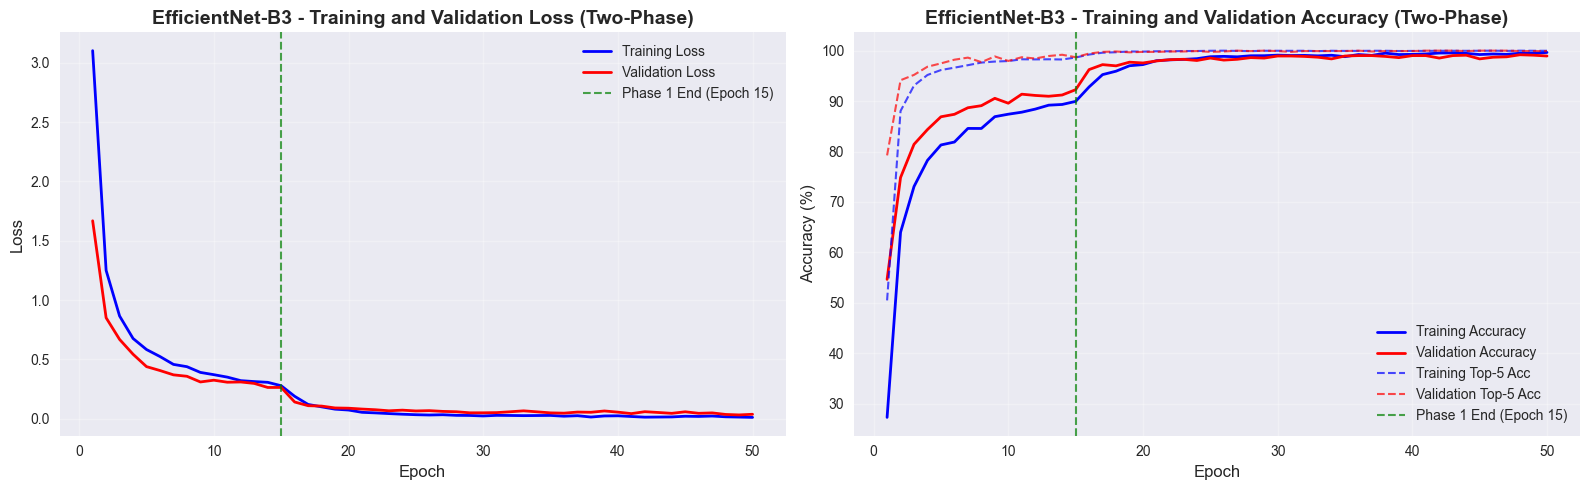

In [20]:
# Load EfficientNet-B3 training metrics from saved file (combined history)
print("Loading EfficientNet-B3 training metrics...")
# Use config if available, otherwise use hardcoded values
if 'EFFICIENTNET_CONFIG' in globals():
    model_name = EFFICIENTNET_CONFIG['model_name']
    metrics_dir = EFFICIENTNET_CONFIG['metrics_dir']
    figures_dir = EFFICIENTNET_CONFIG['figures_dir']
    phase1_epochs = EFFICIENTNET_CONFIG['phase1']['epochs']
else:
    # Fallback to hardcoded values if config not defined
    model_name = 'efficientnet_b3'
    metrics_dir = 'results/metrics'
    figures_dir = 'results/figures'
    phase1_epochs = 15  # Default phase1 epochs for EfficientNet-B3

efficientnet_combined_history = load_training_metrics(
    model_name, 
    metrics_dir, 
    phase=None
)

# Visualize EfficientNet-B3 training history (combined)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
epochs_range = range(1, len(efficientnet_combined_history['train_loss']) + 1)

# Loss plot
axes[0].plot(epochs_range, efficientnet_combined_history['train_loss'], 'b-', label='Training Loss', linewidth=2)
axes[0].plot(epochs_range, efficientnet_combined_history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0].axvline(x=phase1_epochs, color='g', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Phase 1 End (Epoch {phase1_epochs})')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('EfficientNet-B3 - Training and Validation Loss (Two-Phase)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs_range, efficientnet_combined_history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
axes[1].plot(epochs_range, efficientnet_combined_history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
axes[1].plot(epochs_range, efficientnet_combined_history['train_top5_acc'], 'b--', label='Training Top-5 Acc', linewidth=1.5, alpha=0.7)
axes[1].plot(epochs_range, efficientnet_combined_history['val_top5_acc'], 'r--', label='Validation Top-5 Acc', linewidth=1.5, alpha=0.7)
axes[1].axvline(x=phase1_epochs, color='g', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Phase 1 End (Epoch {phase1_epochs})')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('EfficientNet-B3 - Training and Validation Accuracy (Two-Phase)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
save_path = Path(figures_dir) / 'efficientnet_b3_training_curves.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"✓ Training curves saved to: {save_path}")
plt.show()

## 6. Model Comparison and Summary

Compare the training results across all three models.

In [24]:
# Model Comparison Summary
print("=" * 80)
print("MODEL TRAINING COMPARISON SUMMARY")
print("=" * 80)

models_summary = []

# Baseline CNN
if 'baseline_history' in locals():
    # Try to get parameters from model if available, otherwise use known value
    try:
        num_params = sum(p.numel() for p in baseline_model.parameters())
    except (NameError, AttributeError):
        num_params = 2500000  # Approximate parameter count for Baseline CNN (Improved)
    
    models_summary.append({
        'Model': 'Baseline CNN (Improved)',
        'Best Val Acc (%)': max(baseline_history['val_acc']),
        'Best Val Top-5 Acc (%)': max(baseline_history['val_top5_acc']),
        'Final Val Acc (%)': baseline_history['val_acc'][-1],
        'Best Val Loss': min(baseline_history['val_loss']),
        'Total Epochs': len(baseline_history['train_loss']),
        'Image Size': '224×224',
        'Parameters': num_params,
    })

# ResNet50
if 'resnet_combined_history' in locals():
    # Try to get parameters from model if available, otherwise use known value
    try:
        num_params = sum(p.numel() for p in resnet_model.parameters())
    except (NameError, AttributeError):
        num_params = 23500000  # Approximate parameter count for ResNet50
    
    models_summary.append({
        'Model': 'ResNet50',
        'Best Val Acc (%)': max(resnet_combined_history['val_acc']),
        'Best Val Top-5 Acc (%)': max(resnet_combined_history['val_top5_acc']),
        'Final Val Acc (%)': resnet_combined_history['val_acc'][-1],
        'Best Val Loss': min(resnet_combined_history['val_loss']),
        'Total Epochs': len(resnet_combined_history['train_loss']),
        'Image Size': '224×224',
        'Parameters': num_params,
    })

# EfficientNet-B3
if 'efficientnet_combined_history' in locals():
    # Try to get parameters from model if available, otherwise use known value
    try:
        num_params = sum(p.numel() for p in efficientnet_model.parameters())
    except (NameError, AttributeError):
        num_params = 10700000  # Approximate parameter count for EfficientNet-B3
    
    models_summary.append({
        'Model': 'EfficientNet-B3',
        'Best Val Acc (%)': max(efficientnet_combined_history['val_acc']),
        'Best Val Top-5 Acc (%)': max(efficientnet_combined_history['val_top5_acc']),
        'Final Val Acc (%)': efficientnet_combined_history['val_acc'][-1],
        'Best Val Loss': min(efficientnet_combined_history['val_loss']),
        'Total Epochs': len(efficientnet_combined_history['train_loss']),
        'Image Size': '300×300',
        'Parameters': num_params,
    })

# Display summary
import pandas as pd
summary_df = pd.DataFrame(models_summary)
if not summary_df.empty:
    print("Training Results Summary:")
    print(summary_df.to_string(index=False))
    
    # Save summary
    summary_path = Path(SHARED_CONFIG['metrics_dir']) / 'model_training_summary.csv'
    summary_df.to_csv(summary_path, index=False)
    print(f"Summary saved to: {summary_path}")
else:
    print("No models have been trained yet.")

print("=" * 80)

MODEL TRAINING COMPARISON SUMMARY
Training Results Summary:
                  Model  Best Val Acc (%)  Best Val Top-5 Acc (%)  Final Val Acc (%)  Best Val Loss  Total Epochs Image Size  Parameters
Baseline CNN (Improved)             85.83                   97.64              83.55       0.443479           150    224×224    11909894
               ResNet50             98.53                   99.92              98.37       0.069528            44    224×224    24609446
        EfficientNet-B3             99.19                  100.00              98.94       0.031144            50    300×300    10700000
Summary saved to: results\metrics\model_training_summary.csv


Loading model training metrics for comparison...
  ✓ Baseline CNN: Using in-memory history
  ✓ ResNet50: Using in-memory history
  ✓ EfficientNet-B3: Using in-memory history

✓ Model comparison visualization saved to: results\figures\model_comparison_training.png
  Compared 3 model(s): Baseline CNN, ResNet50, EfficientNet-B3
  Showing metrics up to epoch 100


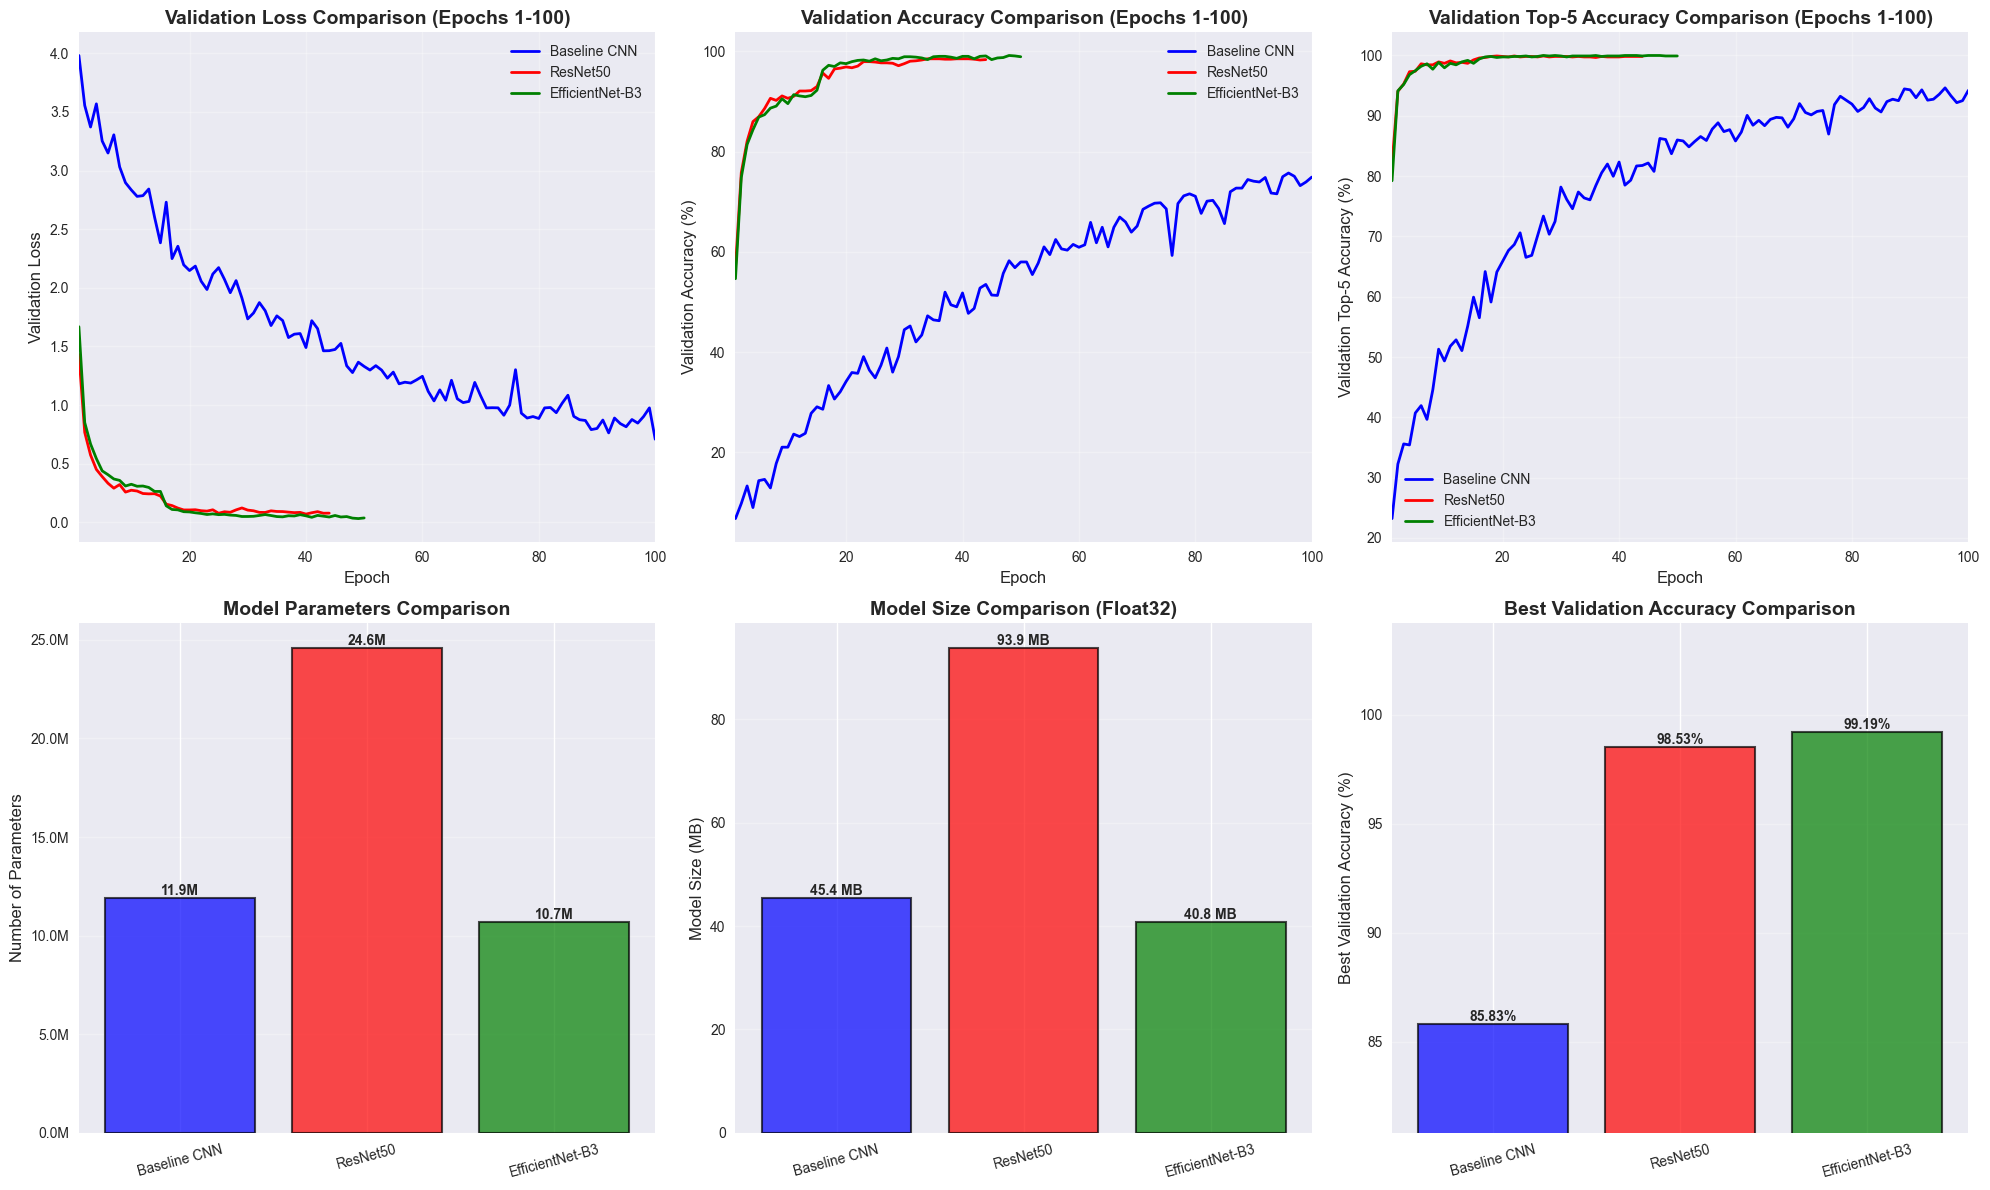

In [27]:
# Visualize comparison of all models (up to epoch 100)
# Load metrics from files if not already in memory
print("Loading model training metrics for comparison...")

available_models = {}
model_configs = [
    ('baseline_history', 'baseline_cnn_improved_no_masks', 'Baseline CNN', 'blue', 'results/metrics'),
    ('resnet_combined_history', 'resnet50', 'ResNet50', 'red', 'results/metrics'),
    ('efficientnet_combined_history', 'efficientnet_b3', 'EfficientNet-B3', 'green', 'results/metrics')
]

# Model parameter information (approximate values if models not available)
model_params_info = {
    'Baseline CNN': {'params': 2500000, 'size_mb': 9.5},
    'ResNet50': {'params': 23500000, 'size_mb': 89.6},
    'EfficientNet-B3': {'params': 10700000, 'size_mb': 40.8}
}

for var_name, model_name, display_name, color, metrics_dir in model_configs:
    # Check if already in locals
    if var_name in locals():
        available_models[display_name] = {
            'history': locals()[var_name],
            'color': color
        }
        print(f"  ✓ {display_name}: Using in-memory history")
    else:
        # Try to load from file
        try:
            history = load_training_metrics(model_name, metrics_dir, phase=None)
            available_models[display_name] = {
                'history': history,
                'color': color
            }
            print(f"  ✓ {display_name}: Loaded from file")
        except (FileNotFoundError, ValueError) as e:
            print(f"  ⚠ {display_name}: Metrics file not found, skipping")
    
    # Try to get actual parameter count from model if available
    model_var_map = {
        'Baseline CNN': 'baseline_model',
        'ResNet50': 'resnet_model',
        'EfficientNet-B3': 'efficientnet_model'
    }
    if display_name in available_models:
        model_var = model_var_map.get(display_name)
        if model_var and model_var in locals():
            try:
                model = locals()[model_var]
                num_params = sum(p.numel() for p in model.parameters())
                model_size_mb = num_params * 4 / (1024 ** 2)  # Assuming float32 (4 bytes per param)
                model_params_info[display_name]['params'] = num_params
                model_params_info[display_name]['size_mb'] = model_size_mb
            except:
                pass  # Use default values

# Create visualization if at least one model is available
if available_models:
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    max_epochs = 100  # Limit to first 100 epochs
    
    # Get figure directory
    if 'SHARED_CONFIG' in globals():
        figures_dir = SHARED_CONFIG['figures_dir']
    else:
        figures_dir = 'results/figures'
    
    # Loss comparison (up to epoch 100) - Row 0, Col 0
    for model_name, model_data in available_models.items():
        history = model_data['history']
        color = model_data['color']
        # Limit to first 100 epochs
        num_epochs = min(len(history['train_loss']), max_epochs)
        epochs = range(1, num_epochs + 1)
        val_loss = history['val_loss'][:num_epochs]
        axes[0, 0].plot(epochs, val_loss, color=color, label=model_name, linewidth=2)
    
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Validation Loss', fontsize=12)
    axes[0, 0].set_title(f'Validation Loss Comparison (Epochs 1-{max_epochs})', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlim([1, max_epochs])
    
    # Accuracy comparison (up to epoch 100) - Row 0, Col 1
    for model_name, model_data in available_models.items():
        history = model_data['history']
        color = model_data['color']
        # Limit to first 100 epochs
        num_epochs = min(len(history['train_loss']), max_epochs)
        epochs = range(1, num_epochs + 1)
        val_acc = history['val_acc'][:num_epochs]
        axes[0, 1].plot(epochs, val_acc, color=color, label=model_name, linewidth=2)
    
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Validation Accuracy (%)', fontsize=12)
    axes[0, 1].set_title(f'Validation Accuracy Comparison (Epochs 1-{max_epochs})', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlim([1, max_epochs])
    
    # Top-5 Accuracy comparison (up to epoch 100) - Row 1, Col 0
    for model_name, model_data in available_models.items():
        history = model_data['history']
        color = model_data['color']
        # Limit to first 100 epochs
        num_epochs = min(len(history['train_loss']), max_epochs)
        epochs = range(1, num_epochs + 1)
        val_top5_acc = history['val_top5_acc'][:num_epochs]
        axes[1, 0].plot(epochs, val_top5_acc, color=color, label=model_name, linewidth=2)
    
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Validation Top-5 Accuracy (%)', fontsize=12)
    axes[1, 0].set_title(f'Validation Top-5 Accuracy Comparison (Epochs 1-{max_epochs})', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim([1, max_epochs])
    
    # Model Parameters Comparison - Row 1, Col 1
    models = list(available_models.keys())
    param_counts = [model_params_info[model]['params'] for model in models]
    colors = [available_models[model]['color'] for model in models]
    
    bars_params = axes[1, 1].bar(models, param_counts, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[1, 1].set_ylabel('Number of Parameters', fontsize=12)
    axes[1, 1].set_title('Model Parameters Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].tick_params(axis='x', rotation=15)
    
    # Format y-axis to show in millions
    ax = axes[1, 1]
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    
    # Add value labels on bars
    for bar, params in zip(bars_params, param_counts):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{params/1e6:.1f}M',
                       ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Model Size Comparison (in MB) - Row 2, Col 0
    model_sizes = [model_params_info[model]['size_mb'] for model in models]
    
    bars_size = axes[2, 0].bar(models, model_sizes, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[2, 0].set_ylabel('Model Size (MB)', fontsize=12)
    axes[2, 0].set_title('Model Size Comparison (Float32)', fontsize=14, fontweight='bold')
    axes[2, 0].grid(True, alpha=0.3, axis='y')
    axes[2, 0].tick_params(axis='x', rotation=15)
    
    # Add value labels on bars
    for bar, size in zip(bars_size, model_sizes):
        height = bar.get_height()
        axes[2, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{size:.1f} MB',
                       ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Best accuracy bar chart - Row 2, Col 1
    best_accs = [max(model_data['history']['val_acc']) for model_data in available_models.values()]
    
    bars_acc = axes[2, 1].bar(models, best_accs, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[2, 1].set_ylabel('Best Validation Accuracy (%)', fontsize=12)
    axes[2, 1].set_title('Best Validation Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[2, 1].grid(True, alpha=0.3, axis='y')
    axes[2, 1].tick_params(axis='x', rotation=15)
    if best_accs:
        axes[2, 1].set_ylim([min(best_accs) - 5, max(best_accs) + 5])
    
    # Add value labels on bars
    for bar, acc in zip(bars_acc, best_accs):
        height = bar.get_height()
        axes[2, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{acc:.2f}%',
                       ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    save_path = Path(figures_dir) / 'model_comparison_training.png'
    Path(figures_dir).mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Model comparison visualization saved to: {save_path}")
    print(f"  Compared {len(available_models)} model(s): {', '.join(available_models.keys())}")
    print(f"  Showing metrics up to epoch {max_epochs}")
    plt.show()
else:
    print("⚠ No model metrics found. Please train at least one model first.")

## 7. Training Summary and Notes

### Key Points:
1. **Baseline CNN**: Custom architecture trained from scratch with improved architecture (deeper layers, more capacity)
2. **ResNet50**: Two-phase transfer learning approach (frozen backbone → fine-tuning)
3. **EfficientNet-B3**: Efficient architecture with higher input resolution (300×300)

### Training Features:
- Class-weighted loss function to handle imbalanced dataset
- Weighted random sampling for balanced batches
- Mixed Precision Training (AMP) for faster training and lower memory usage
- Gradient accumulation for effective larger batch sizes
- Learning rate scheduling with ReduceLROnPlateau
- Early stopping to prevent overfitting

### Results Saved:
- Model checkpoints: `results/models/`
- Training metrics: `results/metrics/`
- Training visualizations: `results/figures/`

### Next Steps:
- Evaluate models on test set (use `04_model_evaluation.ipynb`)
- Generate confusion matrices
- Perform error analysis
- Visualize Grad-CAM attention maps